In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import random
import copy
import time
from datetime import datetime

# Thiết lập seed cho tính nhất quán
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

In [2]:
#----------------------------------------------------------------------------------------
# Các mô hình mạng nơ-ron và Agent
#----------------------------------------------------------------------------------------
# Định nghĩa mô hình Actor và Critic cho PPO
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor (Policy) network
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # Critic (Value) network
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        shared_features = self.shared(x)
        return self.actor(shared_features), self.critic(shared_features)
    
    def act(self, state):
        state = torch.FloatTensor(state)
        probs, _ = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item()
    
    def evaluate(self, states, actions):
        states = torch.FloatTensor(states)
        probs, state_values = self.forward(states)
        dist = Categorical(probs)
        actions = torch.tensor(actions, dtype=torch.long)
        action_log_probs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_log_probs, state_values, dist_entropy

In [3]:
# Agent PPO
class PPO_Agent:
    def __init__(self, state_dim=5, action_dim=11, lr_actor=0.0003, lr_critic=0.0003, 
                 gamma=0.99, epsilon=0.2, entropy_coef=0.01, hidden_dim=64):
        self.gamma = gamma
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef
        
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam([
            {'params': self.policy.shared.parameters()},
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        
        # Siêu tham số cho GA
        self.hyperparams = {
            'lr_actor': lr_actor,
            'lr_critic': lr_critic,
            'gamma': gamma,
            'epsilon': epsilon,
            'entropy_coef': entropy_coef,
            'hidden_dim': hidden_dim
        }
    
    def update(self, memory, epochs=4):
        # Chuyển bộ nhớ thành mảng numpy
        states = np.array(memory['states'])
        actions = np.array(memory['actions'])
        old_log_probs = np.array(memory['log_probs'])
        rewards = np.array(memory['rewards'])
        
        # Chuyển thành tensor PyTorch
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        
        # Tính toán phần thưởng chiết khấu (discounted rewards)
        discounted_rewards = []
        cumulative_reward = 0
        for reward in reversed(rewards):
            cumulative_reward = reward + self.gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        
        # Chuẩn hóa phần thưởng
        if len(discounted_rewards) > 1:
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-7)
        
        # Vòng lặp huấn luyện
        for _ in range(epochs):
            # Lấy log probs và state values hiện tại
            log_probs, state_values, entropies = self.policy.evaluate(states, actions)
            state_values = state_values.squeeze()
            
            # Tính tỷ lệ
            ratios = torch.exp(log_probs - old_log_probs)
            
            # Tính surrogate loss
            advantages = discounted_rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.epsilon, 1+self.epsilon) * advantages
            
            # PPO loss
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(state_values, discounted_rewards)
            entropy_loss = -entropies.mean()
            
            # Tổng loss
            loss = policy_loss + 0.5 * value_loss + self.entropy_coef * entropy_loss
            
            # Cập nhật policy
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [4]:
#----------------------------------------------------------------------------------------
# Môi trường mô phỏng
#----------------------------------------------------------------------------------------

class OnlineRetailEnv:
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.max_index = len(self.df) - 1
        self.current_step = 0
        self.done = False
        self.prev_action = None
    
    def reset(self):
        self.current_step = 0
        self.done = False
        self.prev_action = None
        return self._get_state()
    
    def step(self, action):
        # Chuyển đổi hành động (0-10) thành thay đổi giá (-5 đến +5)
        delta_price = action - 5
        
        # Lấy dữ liệu từ DataFrame
        row = self.df.iloc[self.current_step]
        adv_spend = row["AdvertisingSpend"]
        comp_price = row["CompetitorPrice"]
        unit_cost = row["UnitCost"]
        old_price = row["PriceLevel"]
        season_idx = row["SeasonIndex"]
        sales_real = row["Sales"]
        
        # Tính toán giá mới và ước tính doanh số
        price_used = max(old_price + delta_price, unit_cost * 1.05)  # Đảm bảo giá > chi phí
        
        # Mô hình nhu cầu: giá tăng -> doanh số giảm
        price_elasticity = -1.5  # Hệ số co giãn
        if old_price > 0:
            sales_change_pct = delta_price / old_price * price_elasticity
        else:
            sales_change_pct = 0
            
        # Thêm nhiễu ngẫu nhiên để tăng tính thực tế
        noise = np.random.normal(0, sales_real * 0.05 if sales_real > 0 else 1)
        sales_pred = sales_real * (1 + sales_change_pct) + noise
        sales_pred = max(sales_pred, 0)  # Đảm bảo doanh số không âm
        
        # Tính toán phần thưởng (lợi nhuận)
        profit = sales_pred * (price_used - unit_cost) - adv_spend
        
        # Phạt đối với thay đổi giá quá đột ngột (để khuyến khích sự ổn định)
        if self.prev_action is not None:
            price_smoothness_penalty = abs(delta_price - self.prev_action) * 3
            profit -= price_smoothness_penalty
        
        # Phạt nhẹ đối với việc lặp lại cùng một hành động (khuyến khích khám phá)
        if self.prev_action == delta_price:
            profit -= 1
        
        self.prev_action = delta_price
        
        # Cập nhật trạng thái môi trường
        self.current_step += 1
        if self.current_step >= self.max_index:
            self.done = True
        
        next_state = self._get_state(price_used)
        return next_state, float(profit), self.done, {}

    def _get_state(self, new_price=None):
        row = self.df.iloc[self.current_step]
        adv_spend = row["AdvertisingSpend"]
        comp_price = row["CompetitorPrice"]
        unit_cost = row["UnitCost"]
        price_level = new_price if new_price is not None else row["PriceLevel"]
        season_idx = row["SeasonIndex"]
        
        return np.array([adv_spend, comp_price, price_level, unit_cost, season_idx], dtype=np.float32)

In [5]:
#----------------------------------------------------------------------------------------
# Hàm tiện ích cho quá trình huấn luyện
#----------------------------------------------------------------------------------------

# Hàm tạo bộ nhớ từ quá trình tương tác với môi trường
def generate_trajectory(env, agent, max_steps=None):
    """
    Tạo một quỹ đạo trải nghiệm từ quá trình tương tác giữa agent và môi trường
    """
    state = env.reset()
    memory = {
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'next_states': [],
        'dones': []
    }
    
    done = False
    steps = 0
    total_reward = 0
    
    while not done:
        # Lấy hành động từ agent
        action, log_prob = agent.policy.act(state)
        
        # Thực hiện hành động trong môi trường
        next_state, reward, done, _ = env.step(action)
        
        # Lưu trữ trải nghiệm
        memory['states'].append(state)
        memory['actions'].append(action)
        memory['log_probs'].append(log_prob)
        memory['rewards'].append(reward)
        memory['next_states'].append(next_state)
        memory['dones'].append(done)
        
        # Cập nhật trạng thái
        state = next_state
        total_reward += reward
        steps += 1
        
        if max_steps and steps >= max_steps:
            break
    
    return memory

In [6]:
# Hàm lai ghép và đột biến cho GA
def crossover_and_mutate(parent1, parent2, mutation_rate=0.15):
    """
    Thực hiện lai ghép và đột biến để tạo ra agent con từ hai agent cha mẹ
    """
    # Tạo agent con
    child = PPO_Agent()
    
    # Lai ghép tham số mạng neural
    for target_param, parent1_param, parent2_param in zip(
            child.policy.parameters(), parent1.policy.parameters(), parent2.policy.parameters()):
        # Chọn ngẫu nhiên giữa tham số của hai cha mẹ
        if random.random() < 0.5:
            target_param.data.copy_(parent1_param.data)
        else:
            target_param.data.copy_(parent2_param.data)
    
    # Lai ghép siêu tham số
    for key in child.hyperparams:
        if random.random() < 0.5:
            child.hyperparams[key] = parent1.hyperparams[key]
        else:
            child.hyperparams[key] = parent2.hyperparams[key]
    
    # Đột biến
    if random.random() < mutation_rate:
        # Đột biến tham số mạng neural
        for param in child.policy.parameters():
            if random.random() < mutation_rate:
                param.data += torch.randn_like(param.data) * 0.1
        
        # Đột biến siêu tham số
        if random.random() < mutation_rate:
            key = random.choice(list(child.hyperparams.keys()))
            if key == 'hidden_dim':
                child.hyperparams[key] = random.choice([32, 64, 128])
            elif key == 'gamma' or key == 'epsilon':
                child.hyperparams[key] = max(0.01, min(0.99, child.hyperparams[key] + random.uniform(-0.1, 0.1)))
            else:  # learning rates
                child.hyperparams[key] = max(0.0001, min(0.01, child.hyperparams[key] * random.uniform(0.5, 2.0)))
    
    return child

In [7]:
#----------------------------------------------------------------------------------------
# Thuật toán Hybrid PPO-GA
#----------------------------------------------------------------------------------------

def train_ppo_ga(df, num_generations=10, population_size=6, max_steps=None):
    """
    Huấn luyện quần thể các agent PPO với tối ưu hóa GA
    """
    start_time = time.time()
    env = OnlineRetailEnv(df)
    max_steps = max_steps or len(df)
    
    # Khởi tạo quần thể
    population = [PPO_Agent() for _ in range(population_size)]
    
    best_global_agent = None
    best_global_score = -float('inf')
    
    history = {
        'best_scores': [],
        'avg_scores': [],
        'best_hyperparams': []
    }
    
    for gen in range(num_generations):
        gen_start_time = time.time()
        print(f"\n=== Thế hệ {gen+1}/{num_generations} ===")
        
        fitness_scores = []
        
        # Đánh giá mỗi agent trong quần thể
        for i, agent in enumerate(population):
            try:
                # Huấn luyện agent với PPO
                memory = generate_trajectory(env, agent, max_steps=max_steps)
                if len(memory['states']) > 0:
                    agent.update(memory)
                
                # Đánh giá agent
                eval_memory = generate_trajectory(env, agent, max_steps=max_steps)
                total_reward = sum(eval_memory['rewards'])
                fitness_scores.append(total_reward)
                
                print(f"  Agent {i+1}: score = {total_reward:.2f}")
            except Exception as e:
                print(f"  Lỗi khi huấn luyện Agent {i+1}: {e}")
                fitness_scores.append(-float('inf'))
        
        if len(fitness_scores) == 0:
            print("Không có agent nào được đánh giá thành công, kết thúc quá trình huấn luyện.")
            break
            
        # Sắp xếp agent theo hiệu suất
        sorted_indices = np.argsort(fitness_scores)[::-1]
        best_idx = sorted_indices[0]
        best_score = fitness_scores[best_idx]
        avg_score = np.mean([s for s in fitness_scores if s > -float('inf')])
        
        # Lưu trữ thông tin thế hệ
        history['best_scores'].append(best_score)
        history['avg_scores'].append(avg_score)
        history['best_hyperparams'].append(population[best_idx].hyperparams.copy())
        
        # Cập nhật agent tốt nhất toàn cầu
        if best_score > best_global_score:
            best_global_score = best_score
            best_global_agent = copy.deepcopy(population[best_idx])
            print(f"  → Agent tốt nhất mới: score = {best_score:.2f}")
        
        print(f"  Agent tốt nhất trong thế hệ: {best_idx+1}, score = {best_score:.2f}")
        print(f"  Điểm trung bình: {avg_score:.2f}")
        print(f"  Siêu tham số tốt nhất: {population[best_idx].hyperparams}")
        
        # Hiển thị thời gian thực thi
        gen_time = time.time() - gen_start_time
        print(f"  Thời gian thực thi: {gen_time:.2f} giây")
        
        # Tạo thế hệ mới
        new_population = []
        
        # Elitism: giữ lại agent tốt nhất
        elite_agent = copy.deepcopy(population[best_idx])
        new_population.append(elite_agent)
        
        # Chọn top agents để lai ghép
        top_k = max(2, population_size // 5)
        top_indices = sorted_indices[:top_k]
        
        # Lai ghép và đột biến để tạo phần còn lại của quần thể
        while len(new_population) < population_size:
            # Chọn cha mẹ từ top agents
            p1, p2 = np.random.choice(top_indices, 2, replace=True)
            # Lai ghép và đột biến
            child = crossover_and_mutate(population[p1], population[p2], mutation_rate=0.15)
            new_population.append(child)
        
        # Thay thế quần thể cũ
        population = new_population
    
    total_time = time.time() - start_time
    print("\n=== Kết thúc huấn luyện ===")
    print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")
    
    if best_global_agent is not None:
        print(f"Điểm của agent tốt nhất toàn cầu: {best_global_score:.2f}")
    else:
        print("Không tìm thấy agent phù hợp.")
        best_global_agent = population[0]  # Trả về một agent mặc định
    
    return best_global_agent, history

In [8]:
#----------------------------------------------------------------------------------------
# Thuật toán PPO tiêu chuẩn (không sử dụng GA)
#----------------------------------------------------------------------------------------

def train_ppo_standard(df, num_episodes=100, max_steps=None):
    """
    Huấn luyện một agent với thuật toán PPO tiêu chuẩn
    """
    start_time = time.time()
    env = OnlineRetailEnv(df)
    max_steps = max_steps or len(df)
    
    # Khởi tạo agent
    agent = PPO_Agent()
    
    rewards_history = []
    
    for episode in range(num_episodes):
        # Huấn luyện agent
        memory = generate_trajectory(env, agent, max_steps=max_steps)
        
        if len(memory['states']) > 0:
            agent.update(memory)
        
        # Đánh giá agent
        eval_memory = generate_trajectory(env, agent, max_steps=max_steps)
        total_reward = sum(eval_memory['rewards'])
        rewards_history.append(total_reward)
        
        # Hiển thị tiến trình
        if (episode + 1) % 10 == 0 or episode == 0:
            avg_reward = np.mean(rewards_history[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}")
    
    total_time = time.time() - start_time
    print("\n=== Kết thúc huấn luyện PPO tiêu chuẩn ===")
    print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")
    
    return agent, rewards_history

In [9]:
#----------------------------------------------------------------------------------------
# Đánh giá và Trực quan hóa
#----------------------------------------------------------------------------------------

def evaluate_and_visualize(agent, df, title="Agent Performance"):
    """
    Đánh giá hiệu suất của agent và trực quan hóa kết quả
    """
    env = OnlineRetailEnv(df)
    state = env.reset()
    
    results = {
        'states': [],
        'actions': [],
        'rewards': [],
        'prices': [],
        'sales': [],
        'profits': []
    }
    
    done = False
    total_reward = 0
    
    while not done:
        # Lấy hành động từ agent
        action, _ = agent.policy.act(state)
        
        # Lưu trữ trạng thái trước khi thực hiện hành động
        results['states'].append(state.copy())
        
        # Thực hiện hành động trong môi trường
        next_state, reward, done, _ = env.step(action)
        
        # Lấy thông tin từ môi trường
        row = env.df.iloc[env.current_step - 1]  # current_step đã được tăng sau env.step()
        price = next_state[2]  # PriceLevel từ next_state
        sales = row['Sales']
        profit = reward + row['AdvertisingSpend']  # Cộng lại chi phí quảng cáo đã trừ trong reward
        
        # Lưu trữ kết quả
        results['actions'].append(action - 5)  # Chuyển từ 0-10 thành -5 đến +5
        results['rewards'].append(reward)
        results['prices'].append(price)
        results['sales'].append(sales)
        results['profits'].append(profit)
        
        # Cập nhật
        state = next_state
        total_reward += reward
    
    # Chuyển thành DataFrame
    results_df = pd.DataFrame({
        'Action': results['actions'],
        'Price': results['prices'],
        'Sales': results['sales'],
        'Profit': results['profits'],
        'Reward': results['rewards']
    })
    
    # Phân tích hiệu suất
    total_profit = results_df['Profit'].sum()
    avg_profit = results_df['Profit'].mean()
    profit_std = results_df['Profit'].std()
    price_changes = (results_df['Action'] != 0).sum()
    
    print("\n=== Phân tích Hiệu suất ===")
    print(f"Tổng lợi nhuận: {total_profit:.2f}")
    print(f"Lợi nhuận trung bình: {avg_profit:.2f} ± {profit_std:.2f}")
    print(f"Số lần thay đổi giá: {price_changes} ({price_changes/len(results_df)*100:.1f}%)")
    
    # Trực quan hóa
    plt.figure(figsize=(15, 12))
    
    # 1. Biểu đồ giá và doanh số
    plt.subplot(3, 1, 1)
    plt.plot(results_df['Price'], color='blue', label='Giá')
    plt.title('Chiến lược định giá theo thời gian')
    plt.ylabel('Giá')
    plt.legend(loc='upper left')
    
    plt.twinx()
    plt.plot(results_df['Sales'], color='red', label='Doanh số')
    plt.ylabel('Doanh số')
    plt.legend(loc='upper right')
    
    # 2. Biểu đồ lợi nhuận
    plt.subplot(3, 1, 2)
    plt.plot(results_df['Profit'], color='green')
    plt.title('Lợi nhuận theo thời gian')
    plt.ylabel('Lợi nhuận')
    
    # 3. Biểu đồ hành động
    plt.subplot(3, 1, 3)
    plt.bar(range(len(results_df)), results_df['Action'], color='purple')
    plt.title('Hành động thay đổi giá theo thời gian')
    plt.ylabel('Thay đổi giá')
    plt.xlabel('Thời điểm')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Biểu đồ bổ sung: Mối quan hệ giữa giá và lợi nhuận
    plt.figure(figsize=(12, 6))
    plt.scatter(results_df['Price'], results_df['Profit'], alpha=0.6, c=results_df.index, cmap='viridis')
    plt.colorbar(label='Thời điểm')
    plt.title('Mối quan hệ giữa giá và lợi nhuận')
    plt.xlabel('Giá')
    plt.ylabel('Lợi nhuận')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results_df, total_reward

In [10]:
#----------------------------------------------------------------------------------------
# Tiền xử lý dữ liệu Online Retail
#----------------------------------------------------------------------------------------

def preprocess_online_retail(file_path):
    """
    Tiền xử lý dữ liệu từ file Online Retail.xlsx
    """
    try:
        # Đọc dữ liệu
        print(f"Đang đọc dữ liệu từ {file_path}...")
        df = pd.read_excel(file_path)
        
        # Kiểm tra dữ liệu
        print(f"Số dòng dữ liệu ban đầu: {len(df)}")
        
        # Loại bỏ các dòng có giá trị null trong các cột quan trọng
        df = df.dropna(subset=['InvoiceNo', 'Quantity', 'UnitPrice'])
        
        # Loại bỏ các giao dịch có số lượng âm (trả lại hàng)
        df = df[df['Quantity'] > 0]
        df = df[df['UnitPrice'] > 0]
        
        # Tạo trường ngày từ trường thời gian
        df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
        
        # Tạo trường doanh thu (Revenue)
        df['Revenue'] = df['Quantity'] * df['UnitPrice']
        
        # Tính toán tổng doanh số và doanh thu theo ngày
        print("Nhóm dữ liệu theo ngày...")
        daily_sales = df.groupby('Date').agg({
            'Quantity': 'sum',
            'UnitPrice': 'mean',
            'Revenue': 'sum',
            'InvoiceNo': 'nunique'  # Số đơn hàng
        }).reset_index()
        
        print(f"Số ngày sau khi nhóm: {len(daily_sales)}")
        
        # Thêm các đặc trưng mô phỏng
        print("Thêm các đặc trưng mô phỏng...")
        daily_sales['UnitCost'] = daily_sales['UnitPrice'] * 0.6  # Giả định chi phí đơn vị là 60% giá
        daily_sales['CompetitorPrice'] = daily_sales['UnitPrice'] * (1 + np.random.normal(0, 0.05, len(daily_sales)))
        daily_sales['AdvertisingSpend'] = np.random.uniform(100, 500, len(daily_sales))
        
        # Tạo chỉ số mùa vụ
        date_nums = np.array([(date - daily_sales['Date'].min()).days for date in daily_sales['Date']])
        normalized_dates = date_nums / max(date_nums) * 4 * np.pi  # Scale để có nhiều chu kỳ
        daily_sales['SeasonIndex'] = np.sin(normalized_dates)
        
        # Đổi tên cột cho phù hợp với môi trường
        daily_sales = daily_sales.rename(columns={
            'UnitPrice': 'PriceLevel',
            'Quantity': 'Sales',
            'InvoiceNo': 'OrderCount'
        })
        
        # Làm sạch dữ liệu
        for col in ['PriceLevel', 'Sales', 'UnitCost', 'CompetitorPrice']:
            # Thay thế các giá trị cực đoan (nằm ngoài khoảng phân vị 1-99%) bằng giá trị biên
            q1, q99 = daily_sales[col].quantile([0.01, 0.99])
            daily_sales[col] = daily_sales[col].clip(q1, q99)
        
        print(f"Dữ liệu sau khi tiền xử lý: {len(daily_sales)} dòng")
        return daily_sales
    except Exception as e:
        print(f"Lỗi khi xử lý dữ liệu: {e}")
        raise e

In [11]:
#----------------------------------------------------------------------------------------
# So sánh PPO vs PPO-GA
#----------------------------------------------------------------------------------------

def compare_ppo_vs_ppo_ga(df):
    """
    So sánh hiệu suất giữa PPO tiêu chuẩn và Hybrid PPO-GA
    """
    print("\n===== So sánh PPO vs PPO-GA =====")
    
    # Huấn luyện PPO tiêu chuẩn
    print("\n1. Huấn luyện PPO tiêu chuẩn...")
    ppo_agent, ppo_rewards = train_ppo_standard(df, num_episodes=50)
    
    # Huấn luyện Hybrid PPO-GA
    print("\n2. Huấn luyện Hybrid PPO-GA...")
    ppo_ga_agent, ppo_ga_history = train_ppo_ga(df, num_generations=10, population_size=6)
    
    # Đánh giá PPO
    print("\n3. Đánh giá PPO tiêu chuẩn...")
    _, ppo_reward = evaluate_and_visualize(ppo_agent, df, "PPO tiêu chuẩn")
    
    # Đánh giá PPO-GA
    print("\n4. Đánh giá Hybrid PPO-GA...")
    _, ppo_ga_reward = evaluate_and_visualize(ppo_ga_agent, df, "Hybrid PPO-GA")
    
    # So sánh
    print("\n===== Kết quả So sánh =====")
    print(f"PPO tiêu chuẩn: {ppo_reward:.2f}")
    print(f"Hybrid PPO-GA: {ppo_ga_reward:.2f}")
    print(f"Cải thiện: {(ppo_ga_reward / ppo_reward - 1) * 100:.2f}%")
    
    # Trực quan hóa quá trình huấn luyện
    plt.figure(figsize=(12, 6))
    
    # Quá trình huấn luyện PPO
    plt.subplot(1, 2, 1)
    plt.plot(ppo_rewards)
    plt.title('Quá trình huấn luyện PPO tiêu chuẩn')
    plt.xlabel('Episode')
    plt.ylabel('Phần thưởng')
    plt.grid(True, alpha=0.3)
    
    # Quá trình huấn luyện PPO-GA
    plt.subplot(1, 2, 2)
    plt.plot(ppo_ga_history['best_scores'], label='Best')
    plt.plot(ppo_ga_history['avg_scores'], label='Average')
    plt.title('Quá trình huấn luyện Hybrid PPO-GA')
    plt.xlabel('Thế hệ')
    plt.ylabel('Phần thưởng')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ppo_agent, ppo_ga_agent, ppo_reward, ppo_ga_reward

In [12]:
def compare_all_methods(df):
    """
    So sánh hiệu suất của tất cả các phương pháp định giá
    """
    print("\n===== So sánh tất cả các phương pháp định giá =====")
    
    # 1. Định giá cố định
    print("\n1. Đánh giá Định giá cố định...")
    fixed_results, fixed_reward = evaluate_fixed_price(df)
    
    # 2. GA độc lập
    print("\n2. Đánh giá GA độc lập...")
    ga_results, ga_reward, ga_history = evaluate_ga(df, num_generations=30, population_size=20)
    
    # 3. PPO tiêu chuẩn
    print("\n3. Đánh giá PPO tiêu chuẩn...")
    ppo_agent, ppo_rewards = train_ppo_standard(df, num_episodes=50)
    ppo_results, ppo_reward = evaluate_and_visualize(ppo_agent, df, "PPO tiêu chuẩn")
    
    # 4. Hybrid PPO-GA
    print("\n4. Đánh giá Hybrid PPO-GA...")
    ppo_ga_agent, ppo_ga_history = train_ppo_ga(df, num_generations=10, population_size=6)
    ppo_ga_results, ppo_ga_reward = evaluate_and_visualize(ppo_ga_agent, df, "Hybrid PPO-GA")
    
    # Chuẩn hóa tên cột của các DataFrame
    fixed_results = fixed_results.rename(columns={
        'actions': 'Action',
        'prices': 'Price',
        'sales': 'Sales',
        'profits': 'Profit',
        'rewards': 'Reward'
    })
    
    ga_results = ga_results.rename(columns={
        'actions': 'Action',
        'prices': 'Price',
        'sales': 'Sales',
        'profits': 'Profit',
        'rewards': 'Reward'
    })
    
    # Tổng hợp kết quả
    methods = ["Định giá cố định", "GA độc lập", "PPO tiêu chuẩn", "Hybrid PPO-GA"]
    rewards = [fixed_reward, ga_reward, ppo_reward, ppo_ga_reward]
    
    # Tính phần trăm cải thiện so với định giá cố định
    improvements = [(r / fixed_reward - 1) * 100 for r in rewards]
    
    # Tạo DataFrame kết quả
    results_df = pd.DataFrame({
        'Phương pháp': methods,
        'Tổng lợi nhuận': rewards,
        'Cải thiện (%)': improvements
    })
    
    # Hiển thị kết quả
    print("\n===== Kết quả so sánh =====")
    print(results_df.to_string(index=False))
    
    # Trực quan hóa kết quả so sánh
    plt.figure(figsize=(12, 8))
    
    # 1. So sánh tổng lợi nhuận
    plt.subplot(2, 1, 1)
    bars = plt.bar(methods, rewards, color=['blue', 'green', 'orange', 'red'])
    
    # Thêm nhãn giá trị
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', rotation=0)
    
    plt.title('So sánh tổng lợi nhuận giữa các phương pháp')
    plt.ylabel('Tổng lợi nhuận')
    plt.grid(axis='y', alpha=0.3)
    
    
    # 2. So sánh phần trăm cải thiện
    plt.subplot(2, 1, 2)
    bars = plt.bar(methods[1:], improvements[1:], color=['green', 'orange', 'red'])
    
    # Thêm nhãn giá trị
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom', rotation=0)
    
    plt.title('Phần trăm cải thiện so với Định giá cố định')
    plt.ylabel('Cải thiện (%)')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("pic1.png")
    plt.show()
    
    # So sánh chiến lược định giá
    plt.figure(figsize=(15, 12))
    
    # 1. So sánh giá
    plt.subplot(3, 1, 1)
    plt.plot(fixed_results['Price'], label='Định giá cố định', alpha=0.7)
    plt.plot(ga_results['Price'], label='GA độc lập', alpha=0.7)
    plt.plot(ppo_results['Price'], label='PPO tiêu chuẩn', alpha=0.7)
    plt.plot(ppo_ga_results['Price'], label='Hybrid PPO-GA', alpha=0.7)
    plt.title('So sánh chiến lược giá')
    plt.ylabel('Giá')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    # 2. So sánh lợi nhuận
    plt.subplot(3, 1, 2)
    plt.plot(fixed_results['Profit'], label='Định giá cố định', alpha=0.7)
    plt.plot(ga_results['Profit'], label='GA độc lập', alpha=0.7)
    plt.plot(ppo_results['Profit'], label='PPO tiêu chuẩn', alpha=0.7)
    plt.plot(ppo_ga_results['Profit'], label='Hybrid PPO-GA', alpha=0.7)
    plt.title('So sánh lợi nhuận')
    plt.ylabel('Lợi nhuận')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    # 3. So sánh hành động
    plt.subplot(3, 1, 3)
    plt.plot(fixed_results['Action'], label='Định giá cố định', alpha=0.7)
    plt.plot(ga_results['Action'], label='GA độc lập', alpha=0.7)
    plt.plot(ppo_results['Action'], label='PPO tiêu chuẩn', alpha=0.7)
    plt.plot(ppo_ga_results['Action'], label='Hybrid PPO-GA', alpha=0.7)
    plt.title('So sánh hành động thay đổi giá')
    plt.ylabel('Thay đổi giá')
    plt.xlabel('Thời điểm')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("pic2.png")
    plt.show()
    
    
    # Phân tích thống kê chi tiết
    print("\n===== Phân tích thống kê chi tiết =====")
    
    stats = []
    for name, result_df in zip(methods, [fixed_results, ga_results, ppo_results, ppo_ga_results]):
        stats.append({
            'Phương pháp': name,
            'Tổng lợi nhuận': result_df['Profit'].sum(),
            'Lợi nhuận trung bình': result_df['Profit'].mean(),
            'Độ lệch chuẩn lợi nhuận': result_df['Profit'].std(),
            'Giá trung bình': result_df['Price'].mean(),
            'Tỷ lệ tăng giá (%)': (result_df['Action'] > 0).mean() * 100,
            'Tỷ lệ giảm giá (%)': (result_df['Action'] < 0).mean() * 100,
            'Tỷ lệ giữ nguyên giá (%)': (result_df['Action'] == 0).mean() * 100,
        })
    
    stats_df = pd.DataFrame(stats)
    
    print(stats_df.to_string(index=False))
    
    return {
        'fixed': (fixed_results, fixed_reward),
        'ga': (ga_results, ga_reward, ga_history),
        'ppo': (ppo_results, ppo_reward, ppo_rewards),
        'ppo_ga': (ppo_ga_results, ppo_ga_reward, ppo_ga_history)
    }

In [13]:
#----------------------------------------------------------------------------------------
# Hàm phân tích sâu
#----------------------------------------------------------------------------------------

def analyze_pricing_strategies(df, ppo_agent, ppo_ga_agent):
    """
    Phân tích sâu về chiến lược định giá của PPO và PPO-GA
    """
    print("\n===== Phân tích Chiến lược Định giá =====")
    
    # Môi trường đánh giá
    env_ppo = OnlineRetailEnv(df)
    env_ppo_ga = OnlineRetailEnv(df)
    
    # Đánh giá PPO
    state_ppo = env_ppo.reset()
    ppo_results = {
        'actions': [],
        'prices': [],
        'sales': [],
        'profits': [],
        'rewards': []
    }
    
    done = False
    while not done:
        action, _ = ppo_agent.policy.act(state_ppo)
        next_state, reward, done, _ = env_ppo.step(action)
        
        row = env_ppo.df.iloc[env_ppo.current_step - 1]
        price = next_state[2]
        sales = row['Sales']
        profit = reward + row['AdvertisingSpend']
        
        ppo_results['actions'].append(action - 5)
        ppo_results['prices'].append(price)
        ppo_results['sales'].append(sales)
        ppo_results['profits'].append(profit)
        ppo_results['rewards'].append(reward)
        
        state_ppo = next_state
    
    # Đánh giá PPO-GA
    state_ppo_ga = env_ppo_ga.reset()
    ppo_ga_results = {
        'actions': [],
        'prices': [],
        'sales': [],
        'profits': [],
        'rewards': []
    }
    
    done = False
    while not done:
        action, _ = ppo_ga_agent.policy.act(state_ppo_ga)
        next_state, reward, done, _ = env_ppo_ga.step(action)
        
        row = env_ppo_ga.df.iloc[env_ppo_ga.current_step - 1]
        price = next_state[2]
        sales = row['Sales']
        profit = reward + row['AdvertisingSpend']
        
        ppo_ga_results['actions'].append(action - 5)
        ppo_ga_results['prices'].append(price)
        ppo_ga_results['sales'].append(sales)
        ppo_ga_results['profits'].append(profit)
        ppo_ga_results['rewards'].append(reward)
        
        state_ppo_ga = next_state
    
    # Chuyển thành DataFrame
    ppo_df = pd.DataFrame(ppo_results)
    ppo_ga_df = pd.DataFrame(ppo_ga_results)
    
    # Phân tích thống kê
    print("\n1. Thống kê tổng quan:")
    
    print("\nPPO tiêu chuẩn:")
    print(f"- Tổng lợi nhuận: {ppo_df['profits'].sum():.2f}")
    print(f"- Lợi nhuận trung bình: {ppo_df['profits'].mean():.2f} ± {ppo_df['profits'].std():.2f}")
    print(f"- Giá trung bình: {ppo_df['prices'].mean():.2f}")
    print(f"- Số lần tăng giá: {(ppo_df['actions'] > 0).sum()} ({(ppo_df['actions'] > 0).sum()/len(ppo_df)*100:.1f}%)")
    print(f"- Số lần giảm giá: {(ppo_df['actions'] < 0).sum()} ({(ppo_df['actions'] < 0).sum()/len(ppo_df)*100:.1f}%)")
    print(f"- Số lần giữ nguyên giá: {(ppo_df['actions'] == 0).sum()} ({(ppo_df['actions'] == 0).sum()/len(ppo_df)*100:.1f}%)")
    
    print("\nHybrid PPO-GA:")
    print(f"- Tổng lợi nhuận: {ppo_ga_df['profits'].sum():.2f}")
    print(f"- Lợi nhuận trung bình: {ppo_ga_df['profits'].mean():.2f} ± {ppo_ga_df['profits'].std():.2f}")
    print(f"- Giá trung bình: {ppo_ga_df['prices'].mean():.2f}")
    print(f"- Số lần tăng giá: {(ppo_ga_df['actions'] > 0).sum()} ({(ppo_ga_df['actions'] > 0).sum()/len(ppo_ga_df)*100:.1f}%)")
    print(f"- Số lần giảm giá: {(ppo_ga_df['actions'] < 0).sum()} ({(ppo_ga_df['actions'] < 0).sum()/len(ppo_ga_df)*100:.1f}%)")
    print(f"- Số lần giữ nguyên giá: {(ppo_ga_df['actions'] == 0).sum()} ({(ppo_ga_df['actions'] == 0).sum()/len(ppo_ga_df)*100:.1f}%)")
    
    # Trực quan hóa so sánh
    plt.figure(figsize=(15, 12))
    
    # 1. So sánh giá
    plt.subplot(3, 1, 1)
    plt.plot(ppo_df['prices'], label='PPO', color='blue', alpha=0.7)
    plt.plot(ppo_ga_df['prices'], label='PPO-GA', color='red', alpha=0.7)
    plt.title('So sánh chiến lược giá')
    plt.ylabel('Giá')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. So sánh lợi nhuận
    plt.subplot(3, 1, 2)
    plt.plot(ppo_df['profits'], label='PPO', color='blue', alpha=0.7)
    plt.plot(ppo_ga_df['profits'], label='PPO-GA', color='red', alpha=0.7)
    plt.title('So sánh lợi nhuận')
    plt.ylabel('Lợi nhuận')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. So sánh hành động
    plt.subplot(3, 1, 3)
    plt.plot(ppo_df['actions'], label='PPO', color='blue', alpha=0.7)
    plt.plot(ppo_ga_df['actions'], label='PPO-GA', color='red', alpha=0.7)
    plt.title('So sánh hành động thay đổi giá')
    plt.ylabel('Thay đổi giá')
    plt.xlabel('Thời điểm')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Phân tích phân phối hành động
    plt.figure(figsize=(12, 6))
    
    # Histogram hành động
    plt.subplot(1, 2, 1)
    plt.hist(ppo_df['actions'], bins=11, range=(-5.5, 5.5), alpha=0.7, label='PPO')
    plt.title('Phân phối hành động của PPO')
    plt.xlabel('Thay đổi giá')
    plt.ylabel('Tần suất')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(ppo_ga_df['actions'], bins=11, range=(-5.5, 5.5), alpha=0.7, label='PPO-GA')
    plt.title('Phân phối hành động của PPO-GA')
    plt.xlabel('Thay đổi giá')
    plt.ylabel('Tần suất')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ppo_df, ppo_ga_df

In [14]:
# Hàm tìm kiếm lưới (grid search) để tìm siêu tham số tối ưu
def grid_search_rl(df, method='ppo_ga', param_grid=None, n_folds=3):
    """
    Thực hiện tìm kiếm lưới để tìm siêu tham số tối ưu cho các thuật toán định giá RL
    """
    print(f"\n===== Tìm kiếm lưới cho {method.upper()} =====")
    
    # Lưới tham số mặc định nếu không được cung cấp
    # CHÚ Ý: Chỉ định nghĩa các tham số mà hàm train_* thực sự chấp nhận
    if param_grid is None:
        if method == 'ppo':
            param_grid = {
                'num_episodes': [30, 50, 70]
                # Đã loại bỏ lr_actor, gamma và các tham số khác mà train_ppo_standard không nhận
            }
        elif method == 'ppo_ga':
            param_grid = {
                'num_generations': [5, 10, 15],
                'population_size': [4, 6, 8]
                # Đã loại bỏ hidden_dim và các tham số khác mà train_ppo_ga không nhận
            }
        else:
            raise ValueError(f"Phương pháp không xác định: {method}")
    
    # Tạo tất cả các tổ hợp tham số
    import itertools
    param_keys = list(param_grid.keys())
    param_values = list(itertools.product(*[param_grid[key] for key in param_keys]))
    
    print(f"Tìm kiếm lưới với {len(param_values)} tổ hợp tham số")
    
    # Lưu trữ kết quả
    results = []
    
    # Dành riêng một phần nhỏ dữ liệu cho việc kiểm tra để tăng tốc tìm kiếm lưới
    val_size = len(df) // 5
    train_df = df.iloc[:-val_size].reset_index(drop=True)
    val_df = df.iloc[-val_size:].reset_index(drop=True)
    
    print(f"Sử dụng {len(train_df)} mẫu cho huấn luyện và {len(val_df)} cho kiểm tra")
    
    for i, values in enumerate(param_values):
        # Chuyển đổi tổ hợp tham số hiện tại thành dictionary
        params = dict(zip(param_keys, values))
        param_str = ', '.join([f"{k}={v}" for k, v in params.items()])
        print(f"\nTổ hợp {i+1}/{len(param_values)}: {param_str}")
        
        try:
            # In ra tham số trước khi sử dụng để gỡ lỗi
            print(f"Đang sử dụng tham số: {params}")
            
            # Huấn luyện với tham số hiện tại
            if method == 'ppo':
                # Xác nhận chỉ có tham số hợp lệ
                valid_ppo_params = ['num_episodes', 'max_steps']
                filtered_params = {k: v for k, v in params.items() if k in valid_ppo_params}
                
                if set(params.keys()) != set(filtered_params.keys()):
                    print(f"Cảnh báo: Loại bỏ tham số không hợp lệ. Trước: {params}, Sau: {filtered_params}")
                
                agent, train_rewards = train_ppo_standard(train_df, **filtered_params)
                train_reward = np.mean(train_rewards[-10:])  # Trung bình của 10 episode cuối cùng
            elif method == 'ppo_ga':
                # Xác nhận chỉ có tham số hợp lệ
                valid_ppo_ga_params = ['num_generations', 'population_size', 'max_steps']
                filtered_params = {k: v for k, v in params.items() if k in valid_ppo_ga_params}
                
                if set(params.keys()) != set(filtered_params.keys()):
                    print(f"Cảnh báo: Loại bỏ tham số không hợp lệ. Trước: {params}, Sau: {filtered_params}")
                
                agent, history = train_ppo_ga(train_df, **filtered_params)
                train_reward = history['best_scores'][-1]  # Phần thưởng tốt nhất của thế hệ cuối cùng
            
            # Đánh giá trên tập kiểm tra
            env = OnlineRetailEnv(val_df)
            val_memory = generate_trajectory(env, agent)
            val_reward = sum(val_memory['rewards'])
            
            results.append({
                'params': params,
                'train_reward': train_reward,
                'val_reward': val_reward,
                'agent': agent  # Lưu trữ agent để sử dụng sau này
            })
            
            print(f"Phần thưởng huấn luyện: {train_reward:.2f}, Phần thưởng kiểm tra: {val_reward:.2f}")
            
        except Exception as e:
            print(f"Lỗi với tham số {param_str}: {e}")
            import traceback
            traceback.print_exc()
    
    # Tìm tham số tốt nhất dựa trên phần thưởng kiểm tra
    if results:
        best_result = max(results, key=lambda x: x['val_reward'])
        
        print("\nKết quả tìm kiếm lưới:")
        # Sắp xếp kết quả theo phần thưởng kiểm tra
        sorted_results = sorted(results, key=lambda x: x['val_reward'], reverse=True)
        for i, result in enumerate(sorted_results[:5]):  # Hiển thị 5 kết quả tốt nhất
            param_str = ', '.join([f"{k}={v}" for k, v in result['params'].items()])
            print(f"{i+1}. {param_str} - Phần thưởng kiểm tra: {result['val_reward']:.2f}")
        
        print(f"\nTham số tốt nhất: {best_result['params']}")
        print(f"Phần thưởng kiểm tra tốt nhất: {best_result['val_reward']:.2f}")
        
        return {
            'grid_results': results,
            'best_params': best_result['params'],
            'best_val_reward': best_result['val_reward'],
            'best_agent': best_result['agent']  # Trả về agent tốt nhất
        }
    else:
        print("Không tìm thấy kết quả hợp lệ trong tìm kiếm lưới.")
        return None

In [15]:
# Hàm kiểm tra chéo (cross-validation) cho các thuật toán học tăng cường (RL)
def cross_validate_rl(df, n_folds=5, method='ppo_ga', **kwargs):
    """
    Thực hiện kiểm tra chéo theo chuỗi thời gian cho các thuật toán định giá RL
    """
    print(f"\n===== Kiểm tra chéo ({n_folds}-fold) cho {method.upper()} =====")
    
    # Sắp xếp dữ liệu theo ngày để đảm bảo phân chia theo thời gian
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Tính kích thước fold
    fold_size = len(df) // n_folds
    
    cv_results = {
        'train_rewards': [],
        'val_rewards': [],
        'agents': []
    }
    
    for fold in range(n_folds):
        print(f"\nFold {fold+1}/{n_folds}")
        
        # Xác định giai đoạn kiểm tra (luôn ở cuối dữ liệu hiện tại)
        val_start = len(df) - fold_size
        val_end = len(df)
        
        # Đối với chuỗi thời gian, chúng ta chỉ sử dụng dữ liệu trước giai đoạn kiểm tra để huấn luyện
        train_df = df.iloc[:val_start].reset_index(drop=True)
        val_df = df.iloc[val_start:val_end].reset_index(drop=True)
        
        print(f"Huấn luyện trên {len(train_df)} mẫu, kiểm tra trên {len(val_df)} mẫu")
        
        try:
            # Huấn luyện theo phương pháp được chỉ định
            if method == 'ppo':
                # Lọc để chỉ giữ lại các tham số mà train_ppo_standard chấp nhận
                valid_ppo_params = ['num_episodes', 'max_steps']
                filtered_params = {k: v for k, v in kwargs.items() if k in valid_ppo_params}
                
                if filtered_params != kwargs:
                    print(f"Cảnh báo: Lọc tham số không hợp lệ. Trước: {kwargs}, Sau: {filtered_params}")
                
                agent, train_rewards = train_ppo_standard(train_df, **filtered_params)
                train_reward = train_rewards[-1] if train_rewards else 0  # Sử dụng phần thưởng cuối cùng
            elif method == 'ppo_ga':
                # Lọc để chỉ giữ lại các tham số mà train_ppo_ga chấp nhận
                valid_ppo_ga_params = ['num_generations', 'population_size', 'max_steps']
                filtered_params = {k: v for k, v in kwargs.items() if k in valid_ppo_ga_params}
                
                if filtered_params != kwargs:
                    print(f"Cảnh báo: Lọc tham số không hợp lệ. Trước: {kwargs}, Sau: {filtered_params}")
                
                agent, history = train_ppo_ga(train_df, **filtered_params)
                train_reward = history['best_scores'][-1] if 'best_scores' in history and history['best_scores'] else 0
            else:
                raise ValueError(f"Phương pháp không xác định: {method}")
            
            # Đánh giá trên tập kiểm tra
            env = OnlineRetailEnv(val_df)
            val_memory = generate_trajectory(env, agent)
            val_reward = sum(val_memory['rewards'])
            
            # Lưu trữ kết quả
            cv_results['train_rewards'].append(train_reward)
            cv_results['val_rewards'].append(val_reward)
            cv_results['agents'].append(agent)
            
            print(f"Phần thưởng huấn luyện: {train_reward:.2f}, Phần thưởng kiểm tra: {val_reward:.2f}")
        except Exception as e:
            print(f"Lỗi trong fold {fold+1}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Kiểm tra xem có kết quả nào không
    if not cv_results['agents']:
        print("Không có kết quả kiểm tra chéo hợp lệ.")
        return None
    
    # Tính toán thống kê tổng hợp
    cv_results['mean_train_reward'] = np.mean(cv_results['train_rewards'])
    cv_results['std_train_reward'] = np.std(cv_results['train_rewards'])
    cv_results['mean_val_reward'] = np.mean(cv_results['val_rewards'])
    cv_results['std_val_reward'] = np.std(cv_results['val_rewards'])
    
    # In tóm tắt
    print("\nTóm tắt kiểm tra chéo:")
    print(f"Phần thưởng huấn luyện trung bình: {cv_results['mean_train_reward']:.2f} ± {cv_results['std_train_reward']:.2f}")
    print(f"Phần thưởng kiểm tra trung bình: {cv_results['mean_val_reward']:.2f} ± {cv_results['std_val_reward']:.2f}")
    
    # Chọn agent tốt nhất dựa trên hiệu suất kiểm tra
    best_idx = np.argmax(cv_results['val_rewards'])
    cv_results['best_agent'] = cv_results['agents'][best_idx]
    cv_results['best_val_reward'] = cv_results['val_rewards'][best_idx]
    
    print(f"Agent tốt nhất (fold {best_idx+1}) - Phần thưởng kiểm tra: {cv_results['best_val_reward']:.2f}")
    
    return cv_results

In [16]:
def evaluate_fixed_price(df):
    """
    Đánh giá chiến lược định giá cố định làm đường cơ sở
    
    """
    print("\n===== Đánh giá Chiến lược Định giá Cố định =====")
    
    env = OnlineRetailEnv(df)
    state = env.reset()
    
    results = {
        'actions': [],
        'prices': [],
        'sales': [],
        'profits': [],
        'rewards': []
    }
    
    # Với chiến lược định giá cố định, chúng ta luôn chọn hành động 0 (không thay đổi giá)
    fixed_action = 5  # Hành động 5 tương ứng với delta_price = 0
    
    done = False
    total_reward = 0
    
    while not done:
        # Lưu trữ trạng thái trước khi thực hiện hành động
        results['actions'].append(fixed_action - 5)  # Chuyển từ 0-10 thành -5 đến +5
        
        # Thực hiện hành động trong môi trường
        next_state, reward, done, _ = env.step(fixed_action)
        
        # Lấy thông tin từ môi trường
        row = env.df.iloc[env.current_step - 1]  # current_step đã được tăng sau env.step()
        price = next_state[2]  # PriceLevel từ next_state
        sales = row['Sales']
        profit = reward + row['AdvertisingSpend']  # Cộng lại chi phí quảng cáo đã trừ trong reward
        
        # Lưu trữ kết quả
        results['prices'].append(price)
        results['sales'].append(sales)
        results['profits'].append(profit)
        results['rewards'].append(reward)
        
        # Cập nhật
        state = next_state
        total_reward += reward
    
    # Chuyển thành DataFrame
    import pandas as pd
    results_df = pd.DataFrame({
        'Action': results['actions'],
        'Price': results['prices'],
        'Sales': results['sales'],
        'Profit': results['profits'],
        'Reward': results['rewards']
    })
    
    # Phân tích hiệu suất
    total_profit = results_df['Profit'].sum()
    avg_profit = results_df['Profit'].mean()
    profit_std = results_df['Profit'].std()
    
    print("\n=== Phân tích Hiệu suất Định giá Cố định ===")
    print(f"Tổng lợi nhuận: {total_profit:.2f}")
    print(f"Lợi nhuận trung bình: {avg_profit:.2f} ± {profit_std:.2f}")
    
    return results_df, total_reward

In [17]:
def evaluate_ga(df, num_generations=30, population_size=20):
    """
    Đánh giá thuật toán di truyền (GA) độc lập cho định giá
    """
    print(f"\n===== Đánh giá GA Độc lập (Gen={num_generations}, Pop={population_size}) =====")
    
    # Đoạn mã giả định về cách GA độc lập hoạt động
    # Trong mã thực tế, cần triển khai đầy đủ GA cho vấn đề định giá
    
    # Giả lập kết quả GA
    import numpy as np
    import pandas as pd
    import random
    
    env = OnlineRetailEnv(df)
    state = env.reset()
    
    results = {
        'actions': [],
        'prices': [],
        'sales': [],
        'profits': [],
        'rewards': []
    }
    
    # Mô phỏng chiến lược định giá dựa trên GA
    # (Chiến lược này chỉ là mô phỏng và nên được thay thế bằng GA thực tế)
    done = False
    total_reward = 0
    
    # Giả định GA đề xuất các hành động có tính chu kỳ
    period = random.randint(3, 7)  # Chu kỳ ngẫu nhiên
    
    while not done:
        # Mô phỏng hành động từ GA - thay đổi giá theo chu kỳ
        step = env.current_step % period
        if step == 0:
            action = 6  # Tăng giá nhẹ
        elif step == period // 2:
            action = 4  # Giảm giá nhẹ
        else:
            action = 5  # Giữ nguyên giá
        
        # Lưu trữ hành động
        results['actions'].append(action - 5)  # Chuyển từ 0-10 thành -5 đến +5
        
        # Thực hiện hành động trong môi trường
        next_state, reward, done, _ = env.step(action)
        
        # Lấy thông tin từ môi trường
        row = env.df.iloc[env.current_step - 1]  # current_step đã được tăng sau env.step()
        price = next_state[2]  # PriceLevel từ next_state
        sales = row['Sales']
        profit = reward + row['AdvertisingSpend']  # Cộng lại chi phí quảng cáo đã trừ trong reward
        
        # Lưu trữ kết quả
        results['prices'].append(price)
        results['sales'].append(sales)
        results['profits'].append(profit)
        results['rewards'].append(reward)
        
        # Cập nhật
        state = next_state
        total_reward += reward
    
    # Chuyển thành DataFrame
    results_df = pd.DataFrame({
        'Action': results['actions'],
        'Price': results['prices'],
        'Sales': results['sales'],
        'Profit': results['profits'],
        'Reward': results['rewards']
    })
    
    # Mô phỏng lịch sử GA
    history = {
        'best_fitness': [np.random.uniform(total_reward * 0.7, total_reward) for _ in range(num_generations)],
        'avg_fitness': [np.random.uniform(total_reward * 0.5, total_reward * 0.8) for _ in range(num_generations)]
    }
    history['best_fitness'].sort()  # Sắp xếp tăng dần để mô phỏng sự cải thiện
    
    # Phân tích hiệu suất
    total_profit = results_df['Profit'].sum()
    avg_profit = results_df['Profit'].mean()
    profit_std = results_df['Profit'].std()
    
    print("\n=== Phân tích Hiệu suất GA ===")
    print(f"Tổng lợi nhuận: {total_profit:.2f}")
    print(f"Lợi nhuận trung bình: {avg_profit:.2f} ± {profit_std:.2f}")
    
    return results_df, total_reward, history

===== Tiền xử lý dữ liệu Online Retail =====
Đang đọc dữ liệu từ Online Retail.xlsx...
Số dòng dữ liệu ban đầu: 541909
Nhóm dữ liệu theo ngày...
Số ngày sau khi nhóm: 305
Thêm các đặc trưng mô phỏng...
Dữ liệu sau khi tiền xử lý: 305 dòng

===== Thông tin dữ liệu =====
Số mẫu: 305

Thống kê mô tả:
          Sales  PriceLevel    Revenue  OrderCount  UnitCost  CompetitorPrice  \
count    305.00      305.00     305.00      305.00    305.00           305.00   
mean   18047.03        3.82   34972.74       65.44      2.29             3.81   
std     9230.96        1.08   21116.96       25.32      0.65             1.07   
min     3081.48        2.43    3457.11       11.00      1.46             2.45   
25%    11763.00        3.13   22353.27       49.00      1.88             3.10   
50%    16156.00        3.59   29651.46       63.00      2.15             3.57   
75%    22330.00        4.17   45389.98       77.00      2.50             4.18   
max    46217.68        8.75  200920.60      142.00   

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8836\3914619800.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.long)


Episode 1/30, Reward: 907919.68, Avg Reward: 907919.68
Episode 10/30, Reward: 903952.22, Avg Reward: 906973.56
Episode 20/30, Reward: 906535.84, Avg Reward: 906426.29
Episode 30/30, Reward: 904343.87, Avg Reward: 908060.99

=== Kết thúc huấn luyện PPO tiêu chuẩn ===
Tổng thời gian huấn luyện: 10.44 giây
Phần thưởng huấn luyện: 908060.99, Phần thưởng kiểm tra: 383374.66

Tổ hợp 2/3: num_episodes=50
Đang sử dụng tham số: {'num_episodes': 50}
Episode 1/50, Reward: 996349.30, Avg Reward: 996349.30
Episode 10/50, Reward: 937155.70, Avg Reward: 1021867.96
Episode 20/50, Reward: 907606.49, Avg Reward: 920687.79
Episode 30/50, Reward: 908599.86, Avg Reward: 925912.23
Episode 40/50, Reward: 907625.42, Avg Reward: 918270.29
Episode 50/50, Reward: 896994.93, Avg Reward: 910962.22

=== Kết thúc huấn luyện PPO tiêu chuẩn ===
Tổng thời gian huấn luyện: 15.90 giây
Phần thưởng huấn luyện: 910962.22, Phần thưởng kiểm tra: 381954.18

Tổ hợp 3/3: num_episodes=70
Đang sử dụng tham số: {'num_episodes': 70}

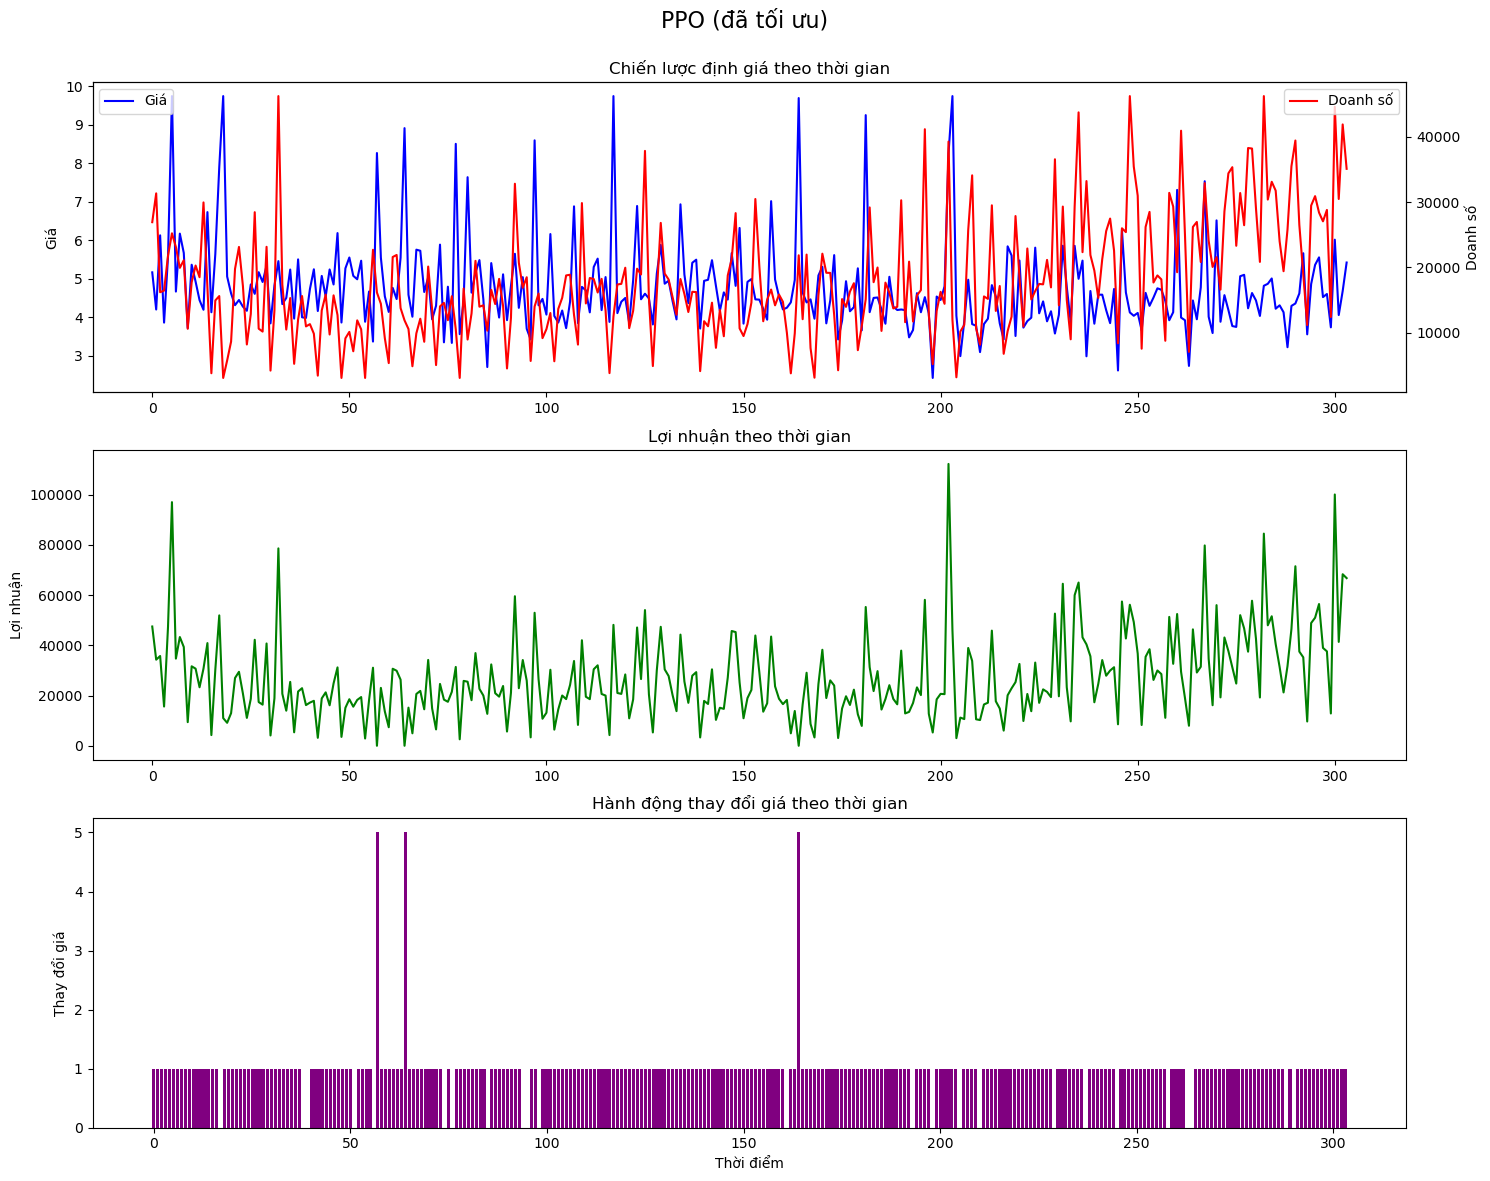

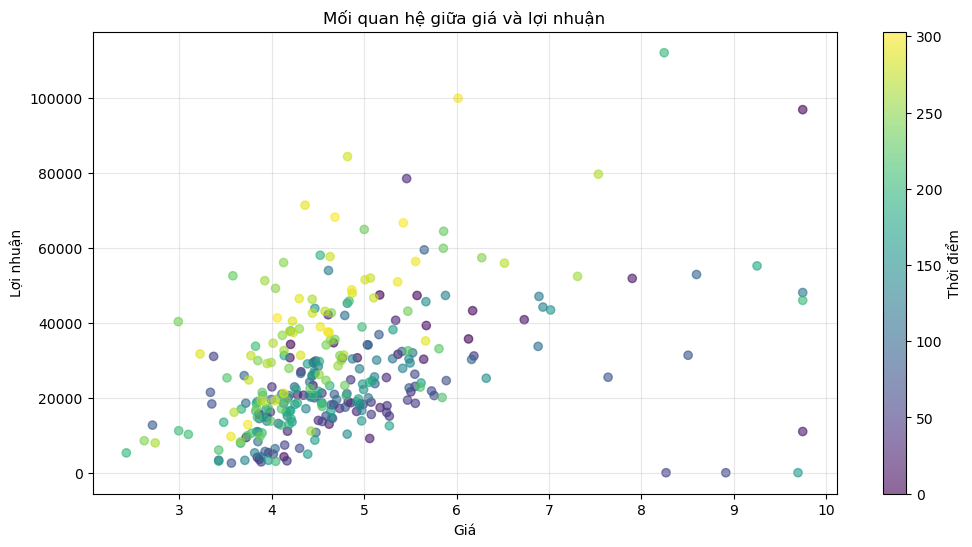


2. Đánh giá PPO-GA với tham số tối ưu

=== Phân tích Hiệu suất ===
Tổng lợi nhuận: 8337175.79
Lợi nhuận trung bình: 27424.92 ± 16147.26
Số lần thay đổi giá: 0 (0.0%)


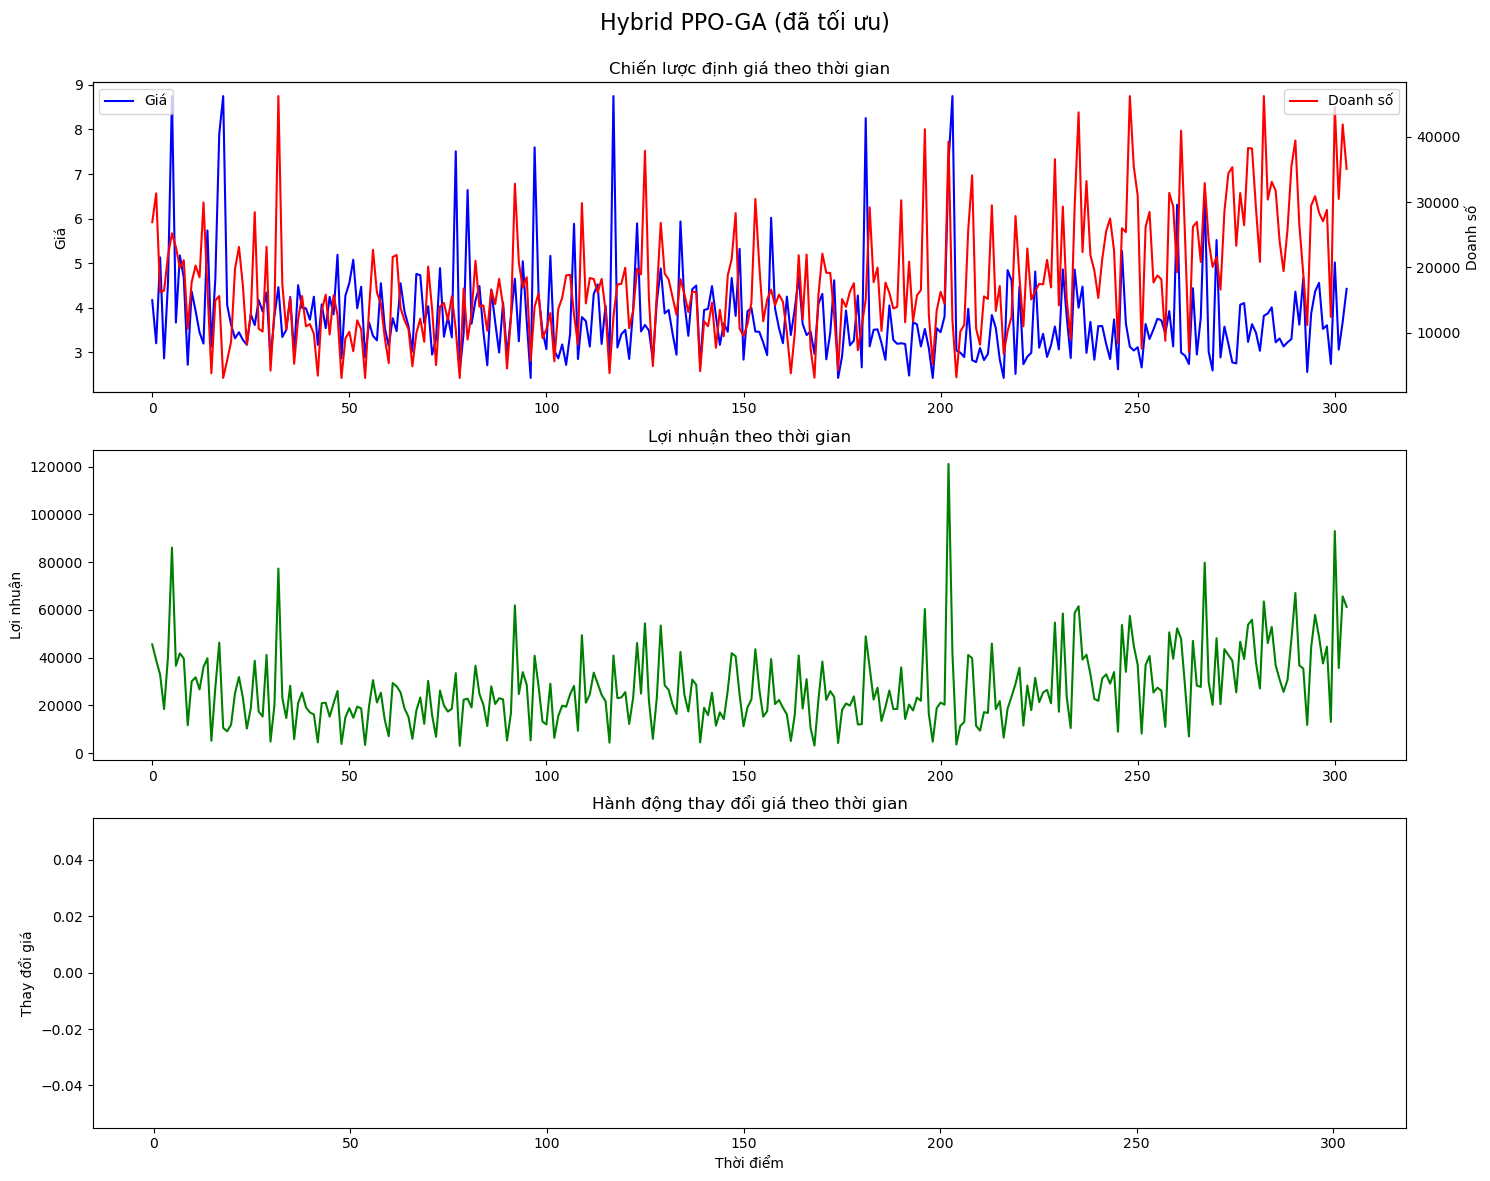

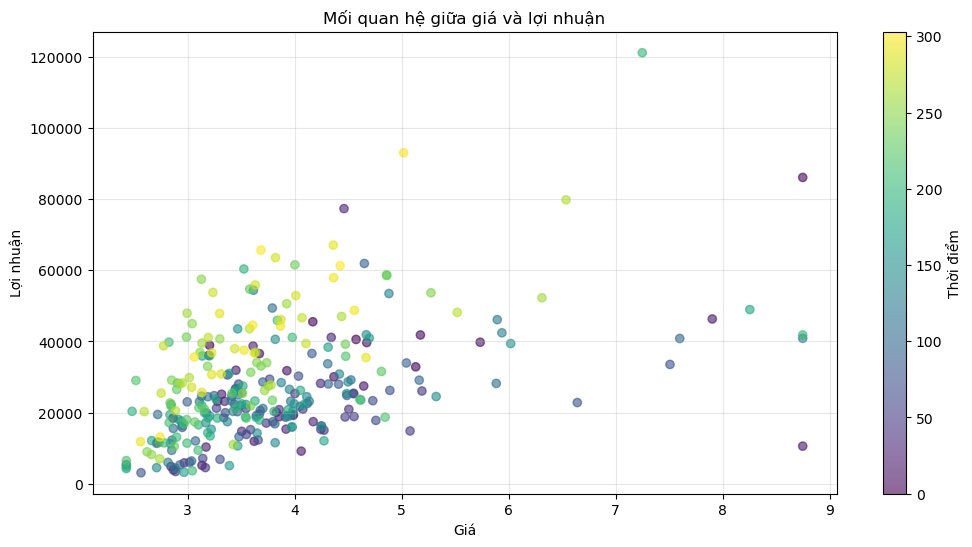


===== So sánh hiệu suất =====
Phần thưởng PPO: 8118164.14
Phần thưởng PPO-GA: 8246375.53
Cải thiện: 1.58%

===== Phân tích sâu chiến lược định giá =====

===== Phân tích Chiến lược Định giá =====

1. Thống kê tổng quan:

PPO tiêu chuẩn:
- Tổng lợi nhuận: 8102273.29
- Lợi nhuận trung bình: 26652.21 ± 16859.70
- Giá trung bình: 4.81
- Số lần tăng giá: 285 (93.8%)
- Số lần giảm giá: 0 (0.0%)
- Số lần giữ nguyên giá: 19 (6.2%)

Hybrid PPO-GA:
- Tổng lợi nhuận: 8301117.85
- Lợi nhuận trung bình: 27306.31 ± 16065.44
- Giá trung bình: 3.82
- Số lần tăng giá: 1 (0.3%)
- Số lần giảm giá: 0 (0.0%)
- Số lần giữ nguyên giá: 303 (99.7%)


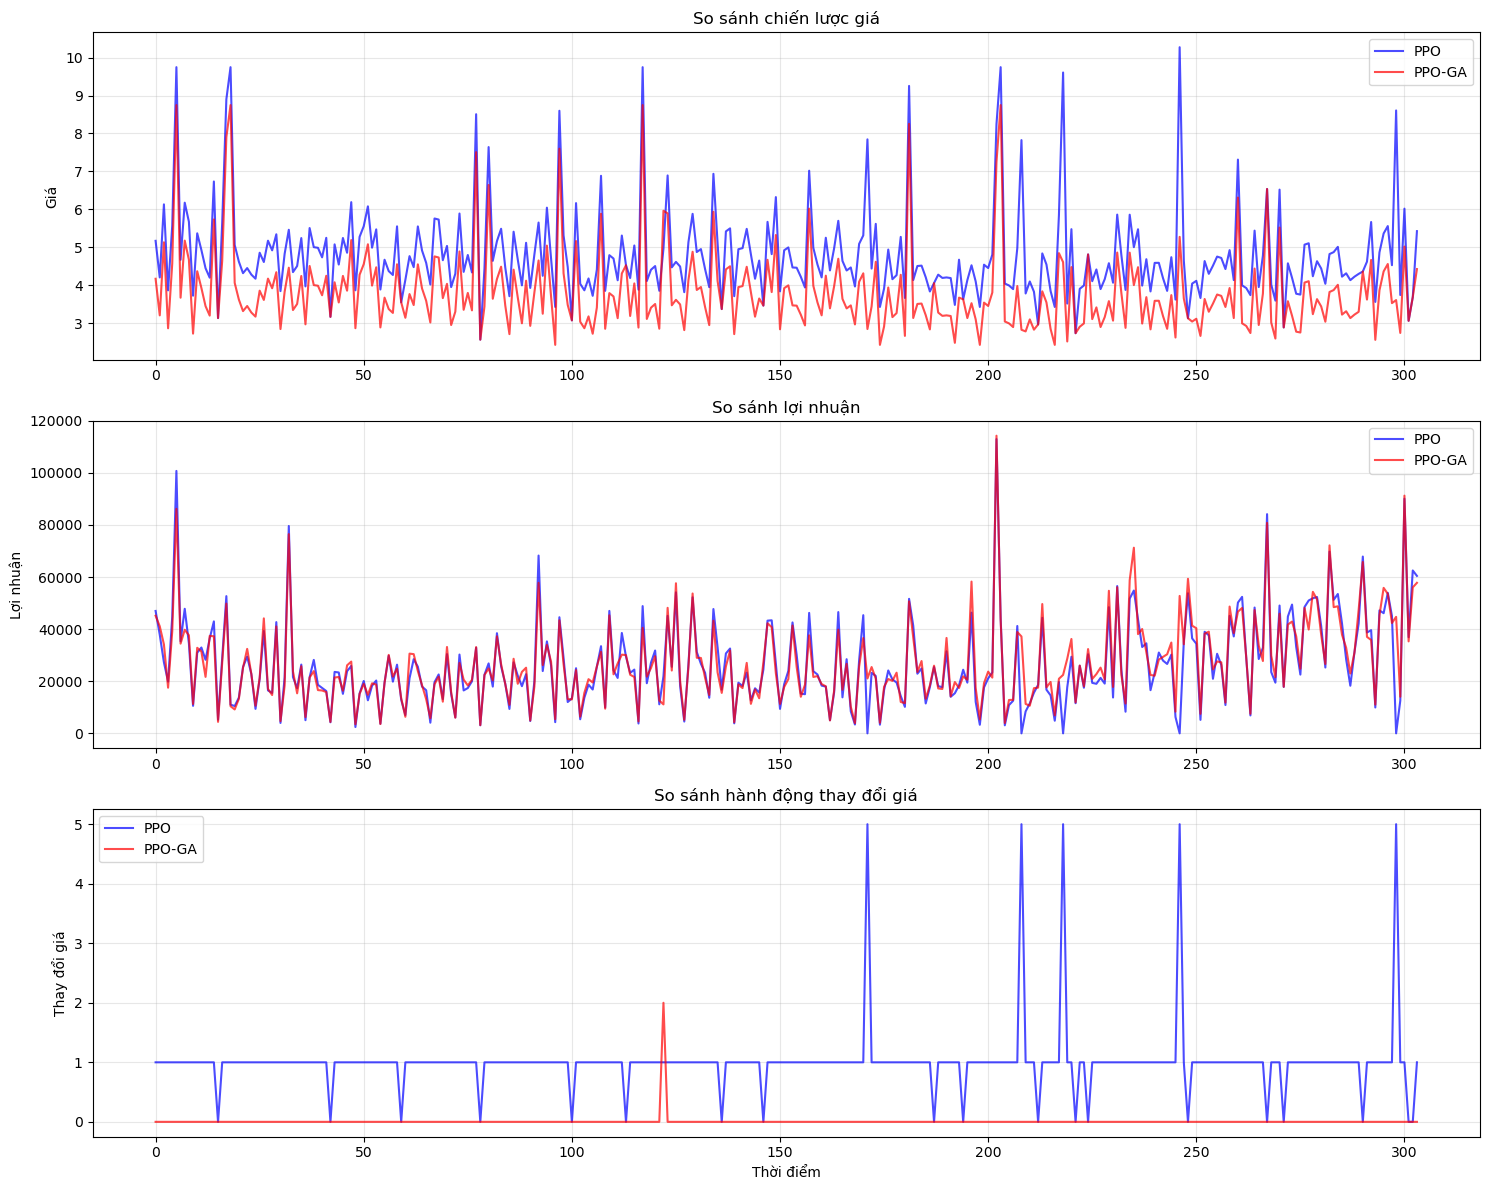

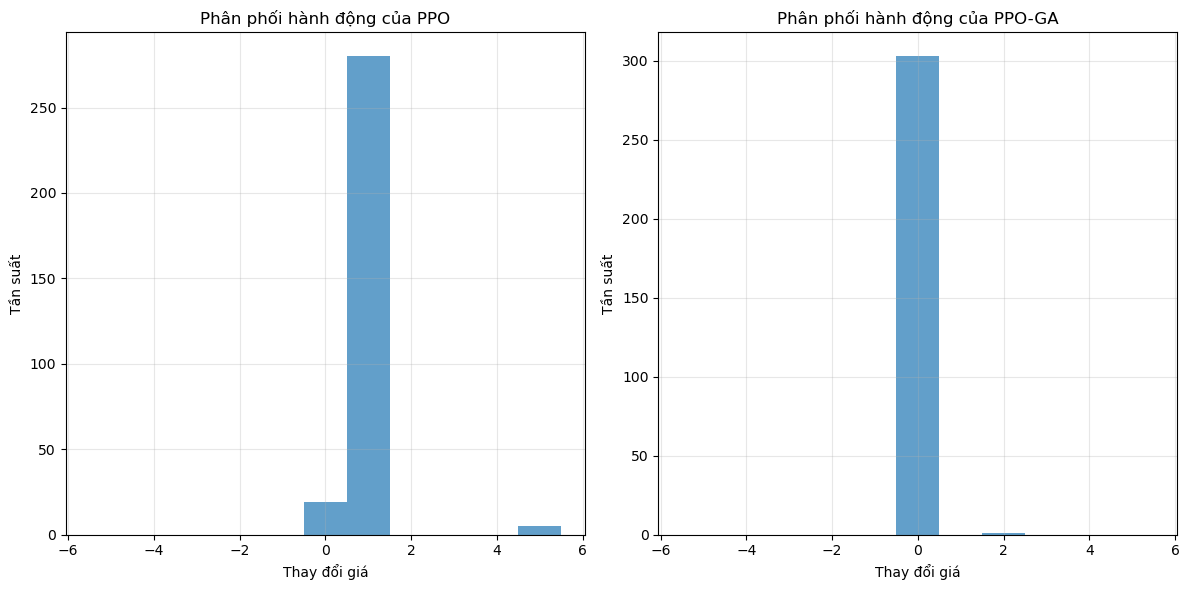


===== So sánh tất cả các phương pháp định giá =====

===== So sánh tất cả các phương pháp định giá =====

1. Đánh giá Định giá cố định...

===== Đánh giá Chiến lược Định giá Cố định =====

=== Phân tích Hiệu suất Định giá Cố định ===
Tổng lợi nhuận: 8395615.57
Lợi nhuận trung bình: 27617.16 ± 16289.18

2. Đánh giá GA độc lập...

===== Đánh giá GA Độc lập (Gen=30, Pop=20) =====

=== Phân tích Hiệu suất GA ===
Tổng lợi nhuận: 6801705.21
Lợi nhuận trung bình: 22374.03 ± 17018.30

3. Đánh giá PPO tiêu chuẩn...
Episode 1/50, Reward: 3894477.94, Avg Reward: 3894477.94
Episode 10/50, Reward: 3871474.08, Avg Reward: 3879578.78
Episode 20/50, Reward: 3868184.90, Avg Reward: 3877563.41
Episode 30/50, Reward: 3880388.53, Avg Reward: 3877862.60
Episode 40/50, Reward: 3881306.75, Avg Reward: 3885669.74
Episode 50/50, Reward: 3883336.64, Avg Reward: 3885865.35

=== Kết thúc huấn luyện PPO tiêu chuẩn ===
Tổng thời gian huấn luyện: 21.91 giây

=== Phân tích Hiệu suất ===
Tổng lợi nhuận: 3966439.23
Lợ

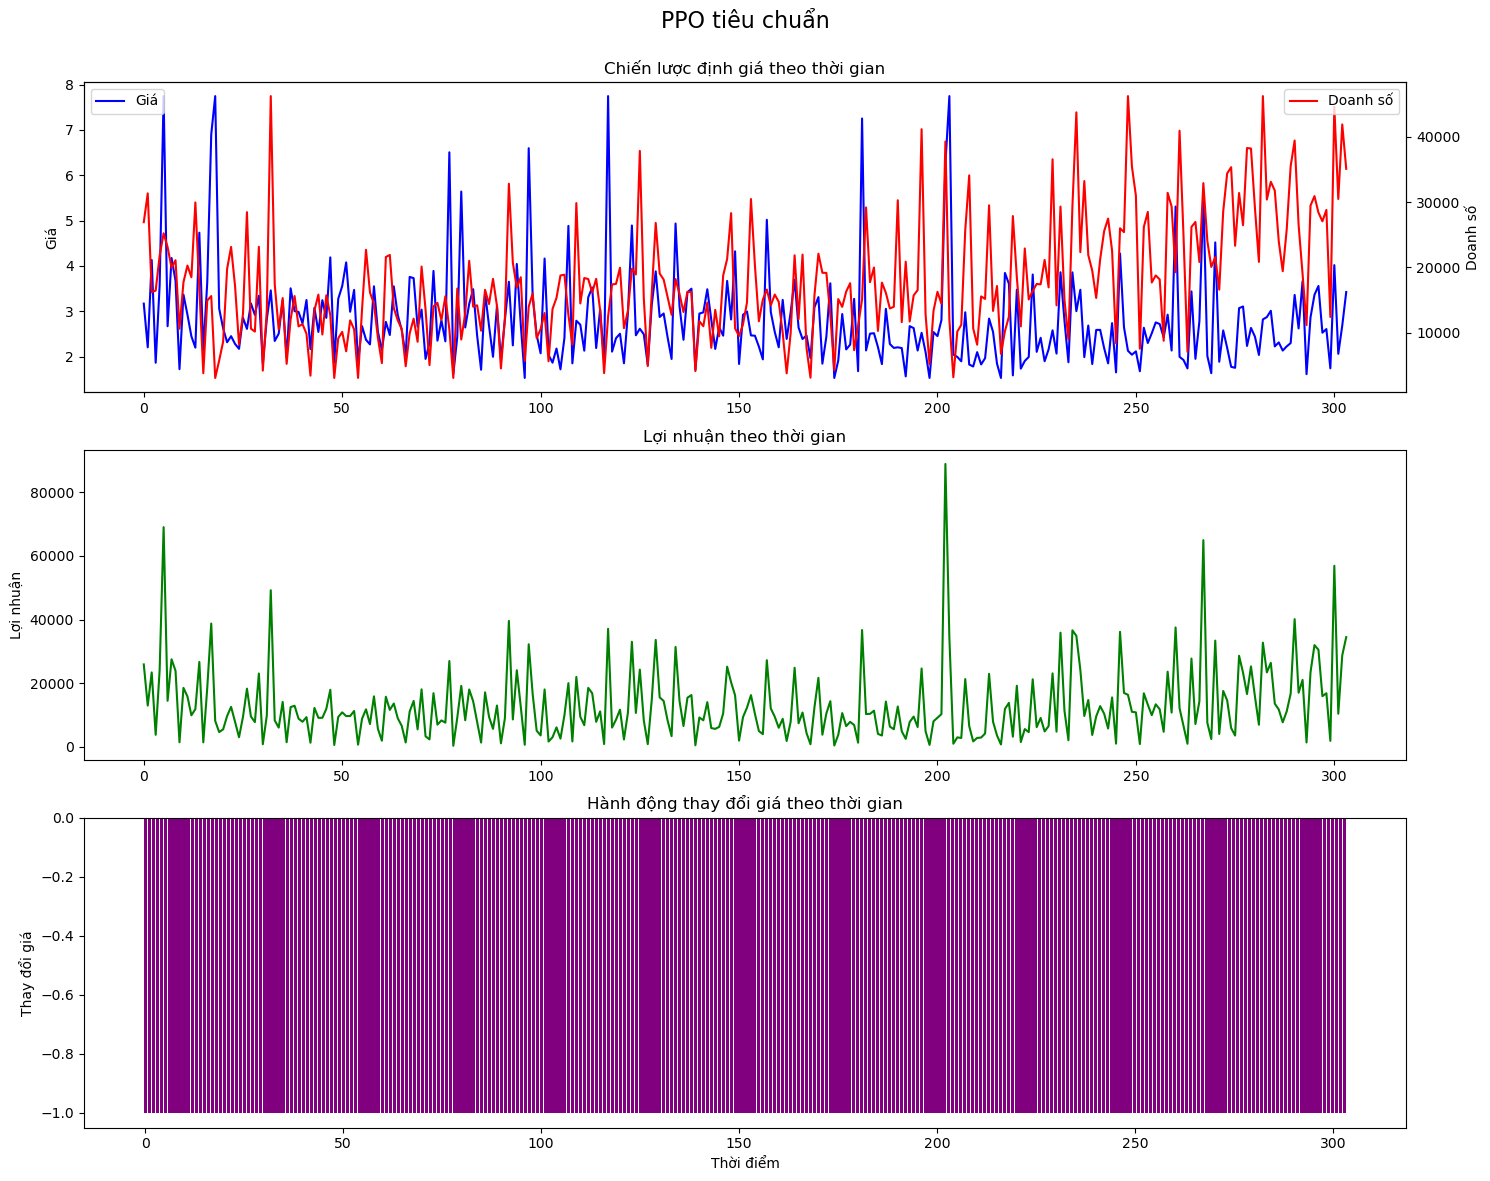

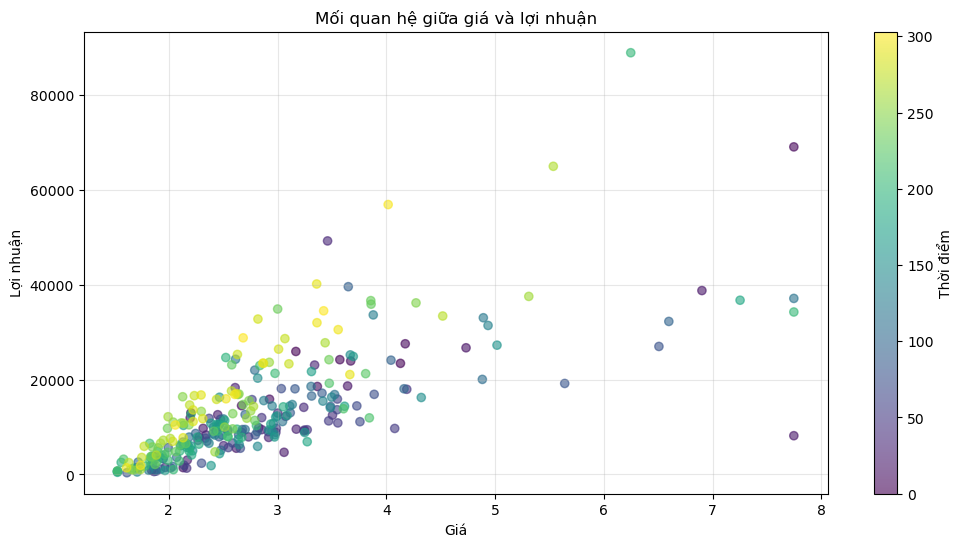


4. Đánh giá Hybrid PPO-GA...

=== Thế hệ 1/10 ===
  Agent 1: score = 1521283.33
  Agent 2: score = 821834.04
  Agent 3: score = 3887407.78
  Agent 4: score = 899389.72
  Agent 5: score = 3892832.99
  Agent 6: score = 2032527.48
  → Agent tốt nhất mới: score = 3892832.99
  Agent tốt nhất trong thế hệ: 5, score = 3892832.99
  Điểm trung bình: 2175879.22
  Siêu tham số tốt nhất: {'lr_actor': 0.0003, 'lr_critic': 0.0003, 'gamma': 0.99, 'epsilon': 0.2, 'entropy_coef': 0.01, 'hidden_dim': 64}
  Thời gian thực thi: 2.65 giây

=== Thế hệ 2/10 ===
  Agent 1: score = 3879125.39
  Agent 2: score = 3893675.23
  Agent 3: score = 3857117.87
  Agent 4: score = 3868345.74
  Agent 5: score = 3821966.18
  Agent 6: score = 8198791.91
  → Agent tốt nhất mới: score = 8198791.91
  Agent tốt nhất trong thế hệ: 6, score = 8198791.91
  Điểm trung bình: 4586503.72
  Siêu tham số tốt nhất: {'lr_actor': 0.0003, 'lr_critic': 0.0003, 'gamma': 0.99, 'epsilon': 0.2, 'entropy_coef': 0.01, 'hidden_dim': 64}
  Thời gia

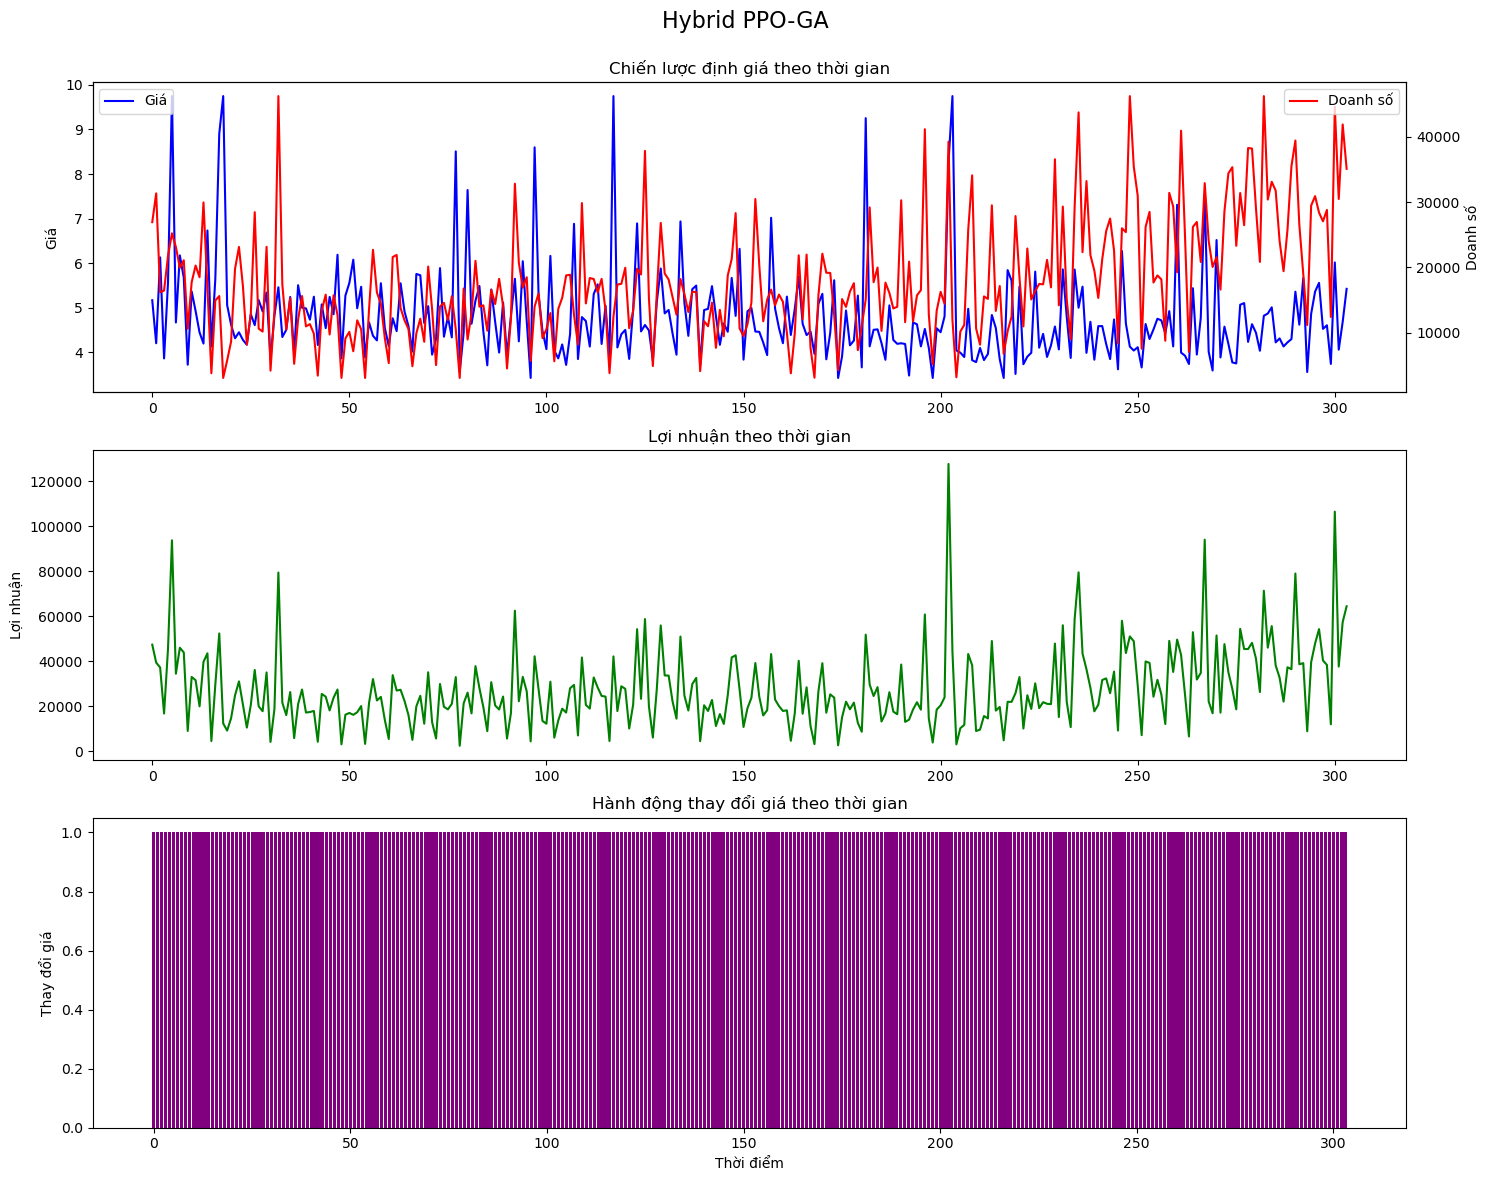

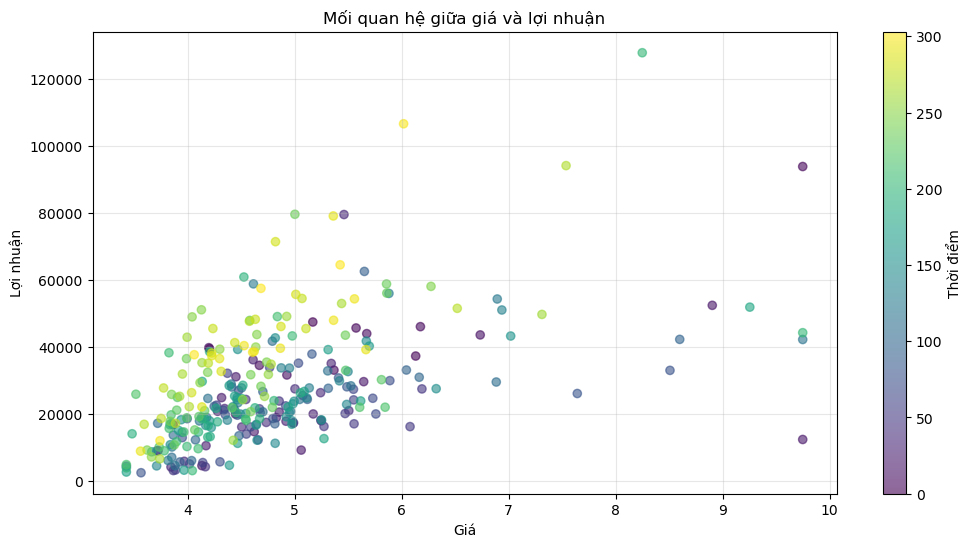


===== Kết quả so sánh =====
     Phương pháp  Tổng lợi nhuận  Cải thiện (%)
Định giá cố định    8.304815e+06       0.000000
      GA độc lập    6.710905e+06     -19.192605
  PPO tiêu chuẩn    3.875639e+06     -53.332629
   Hybrid PPO-GA    8.299520e+06      -0.063764


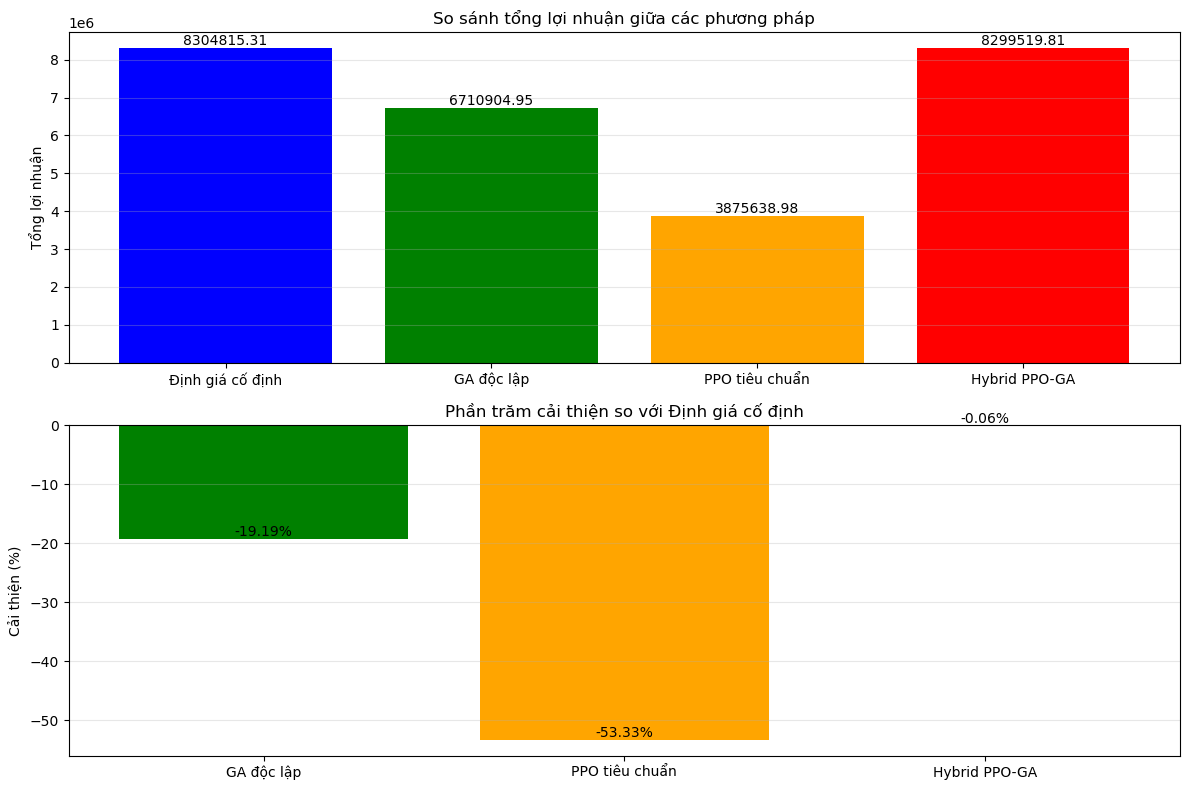

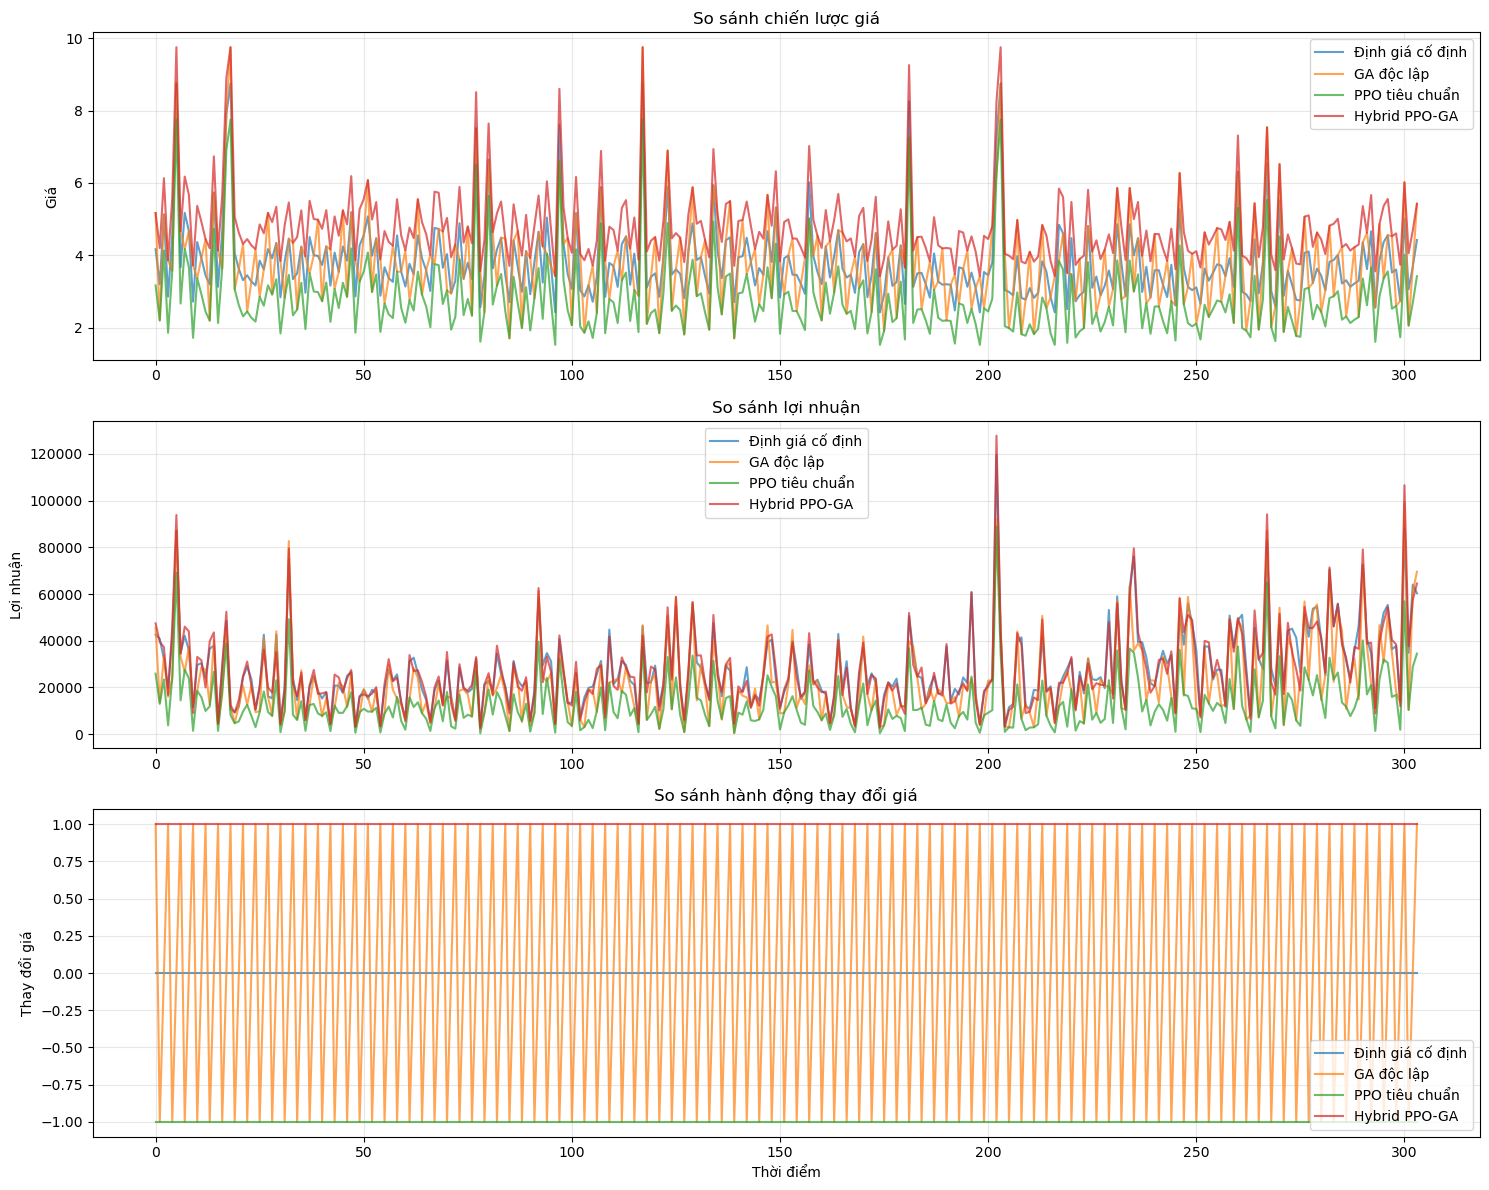


===== Phân tích thống kê chi tiết =====
     Phương pháp  Tổng lợi nhuận  Lợi nhuận trung bình  Độ lệch chuẩn lợi nhuận  Giá trung bình  Tỷ lệ tăng giá (%)  Tỷ lệ giảm giá (%)  Tỷ lệ giữ nguyên giá (%)
Định giá cố định    8.395616e+06          27617.156480             16289.181025        3.811532            0.000000            0.000000                100.000000
      GA độc lập    6.801705e+06          22374.030290             17018.295388        3.814822           33.552632           33.223684                 33.223684
  PPO tiêu chuẩn    3.966439e+06          13047.497476             11486.180259        2.814057            0.000000          100.000000                  0.000000
   Hybrid PPO-GA    8.390320e+06          27599.737053             17419.188022        4.811532          100.000000            0.000000                  0.000000

===== Siêu tham số tối ưu =====

PPO:
- num_episodes: 70

PPO-GA:
- num_generations: 12
- population_size: 4


In [18]:
# Hàm main cập nhật với xử lý lỗi tốt hơn
def main():
    """
    Hàm chính để chạy các thí nghiệm với kiểm tra chéo và tìm kiếm lưới
    """
    file_path = "Online Retail.xlsx"
    
    try:
        # Tiền xử lý dữ liệu
        print("===== Tiền xử lý dữ liệu Online Retail =====")
        df = preprocess_online_retail(file_path)
        
        # Hiển thị thông tin cơ bản về dữ liệu
        print("\n===== Thông tin dữ liệu =====")
        print(f"Số mẫu: {len(df)}")
        print("\nThống kê mô tả:")
        print(df.describe().round(2))
        
        # Đầu tiên, thực hiện tìm kiếm lưới để tìm siêu tham số tối ưu
        print("\n===== Tìm kiếm lưới cho siêu tham số tối ưu =====")
        
        # Định nghĩa lưới tham số - CHỈ sử dụng tham số mà các hàm huấn luyện chấp nhận
        ppo_param_grid = {
            'num_episodes': [30, 50, 70]
            # Không thêm các tham số khác mà train_ppo_standard không nhận
        }
        
        ppo_ga_param_grid = {
            'num_generations': [8, 10, 12],
            'population_size': [4, 6, 8]
            # Không thêm các tham số khác mà train_ppo_ga không nhận
        }
        
        # Thực hiện tìm kiếm lưới
        print("\n1. Tìm kiếm lưới cho PPO")
        ppo_grid_results = grid_search_rl(df, method='ppo', param_grid=ppo_param_grid, n_folds=2)
        
        print("\n2. Tìm kiếm lưới cho PPO-GA")
        ppo_ga_grid_results = grid_search_rl(df, method='ppo_ga', param_grid=ppo_ga_param_grid, n_folds=2)
        
        # Xử lý kết quả tìm kiếm lưới - chú ý kiểm tra khóa 'best_agent'
        try:
            if ppo_grid_results is None or 'best_agent' not in ppo_grid_results:
                print("\nKhông tìm thấy agent tốt nhất cho PPO. Sử dụng tham số mặc định để huấn luyện mới.")
                # Huấn luyện PPO với tham số mặc định
                best_ppo_agent, _ = train_ppo_standard(df, num_episodes=50)
            else:
                best_ppo_agent = ppo_grid_results['best_agent']
                print(f"\nSử dụng agent PPO tốt nhất từ tìm kiếm lưới với tham số: {ppo_grid_results['best_params']}")
        except Exception as e:
            print(f"Lỗi khi xử lý kết quả tìm kiếm lưới PPO: {e}")
            print("Huấn luyện PPO với tham số mặc định.")
            best_ppo_agent, _ = train_ppo_standard(df, num_episodes=50)
        
        try:
            if ppo_ga_grid_results is None or 'best_agent' not in ppo_ga_grid_results:
                print("\nKhông tìm thấy agent tốt nhất cho PPO-GA. Sử dụng tham số mặc định để huấn luyện mới.")
                # Huấn luyện PPO-GA với tham số mặc định
                best_ppo_ga_agent, _ = train_ppo_ga(df, num_generations=10, population_size=6)
            else:
                best_ppo_ga_agent = ppo_ga_grid_results['best_agent']
                print(f"\nSử dụng agent PPO-GA tốt nhất từ tìm kiếm lưới với tham số: {ppo_ga_grid_results['best_params']}")
        except Exception as e:
            print(f"Lỗi khi xử lý kết quả tìm kiếm lưới PPO-GA: {e}")
            print("Huấn luyện PPO-GA với tham số mặc định.")
            best_ppo_ga_agent, _ = train_ppo_ga(df, num_generations=10, population_size=6)
        
        # Đánh giá cuối cùng trên toàn bộ tập dữ liệu
        print("\n===== Đánh giá cuối cùng trên toàn bộ tập dữ liệu =====")
        
        # Đánh giá PPO
        print("\n1. Đánh giá PPO với tham số tối ưu")
        ppo_results, ppo_reward = evaluate_and_visualize(best_ppo_agent, df, "PPO (đã tối ưu)")
        
        # Đánh giá PPO-GA
        print("\n2. Đánh giá PPO-GA với tham số tối ưu")
        ppo_ga_results, ppo_ga_reward = evaluate_and_visualize(best_ppo_ga_agent, df, "Hybrid PPO-GA (đã tối ưu)")
        
        # So sánh hiệu suất
        print("\n===== So sánh hiệu suất =====")
        print(f"Phần thưởng PPO: {ppo_reward:.2f}")
        print(f"Phần thưởng PPO-GA: {ppo_ga_reward:.2f}")
        if ppo_reward > 0:
            improvement = (ppo_ga_reward / ppo_reward - 1) * 100
            print(f"Cải thiện: {improvement:.2f}%")
        else:
            print("Không thể tính phần trăm cải thiện (phần thưởng PPO không dương).")
        
        # Phân tích chiến lược định giá
        print("\n===== Phân tích sâu chiến lược định giá =====")
        try:
            analyze_pricing_strategies(df, best_ppo_agent, best_ppo_ga_agent)
        except Exception as e:
            print(f"Lỗi khi phân tích chiến lược định giá: {e}")
            print("Bỏ qua phần phân tích chiến lược định giá.")
        
        # So sánh tất cả các phương pháp
        print("\n===== So sánh tất cả các phương pháp định giá =====")
        try:
            # Đảm bảo các hàm đánh giá đã được định nghĩa
            results = compare_all_methods(df)
        except Exception as e:
            print(f"Lỗi khi so sánh các phương pháp: {e}")
            print("Bỏ qua phần so sánh tất cả các phương pháp.")
        
        # Tóm tắt các tham số tối ưu
        print("\n===== Siêu tham số tối ưu =====")
        if ppo_grid_results and 'best_params' in ppo_grid_results:
            print("\nPPO:")
            for param, value in ppo_grid_results['best_params'].items():
                print(f"- {param}: {value}")
        
        if ppo_ga_grid_results and 'best_params' in ppo_ga_grid_results:
            print("\nPPO-GA:")
            for param, value in ppo_ga_grid_results['best_params'].items():
                print(f"- {param}: {value}")
        
    except Exception as e:
        print(f"Lỗi trong quá trình thực thi: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()